In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

INFORMATION:

This file lists the films in the MIAS database and provides     
appropriate details as follows:

1st column: MIAS database reference number.

2nd column: Character of background tissue: 
                F - Fatty 
                G - Fatty-glandular
                D - Dense-glandular

3rd column: Class of abnormality present:
                CALC - Calcification
                CIRC - Well-defined/circumscribed masses
                SPIC - Spiculated masses
                MISC - Other, ill-defined masses
                ARCH - Architectural distortion
                ASYM - Asymmetry
                NORM - Normal

4th column: Severity of abnormality;
                B - Benign
                M - Malignant
                
5th,6th columns: x,y image-coordinates of centre of abnormality.

7th column: Approximate radius (in pixels) of a circle enclosing
            the abnormality.
            
NOTES

1- The list is arranged in pairs of films, where each pair 
   represents the left (even filename numbers) and right mammograms
   (odd filename numbers) of a single patient.
   
2- The size of ALL the images is 1024 pixels x 1024 pixels. The images
   have been centered in the matrix.  

3- When calcifications are present, centre locations and radii 
   apply to clusters rather than individual calcifications.
   Coordinate system origin is the bottom-left corner.

4- In some cases calcifications are widely distributed throughout
   the image rather than concentrated at a single site. In these
   cases centre locations and radii are inappropriate and have
   been omitted.

In [2]:
# Combine this for a clean initial work of MIAS Classification of N B M, then move on DDSM or mix it up.

# system related
import os
import sys
import pickle
import itertools

# import tensorflow 
import tensorflow as tf

# keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input, BatchNormalization
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, models

# path manipulation
from pathlib import Path

# regex
import re
import random
import seaborn as sns
# image manipulation
from IPython.display import Image

# data manipulation / preparation
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# data and Image manipulation / preparation
import pandas as pd
import numpy as np
from PIL import Image

# plotting
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

 ### Citation for the class MammoScan and the collection of functions right after.
*    Title: mias_mammography
*    Author: Poles, Carlos
*    Date: 06/2021
*    Availability: https://github.com/cpoles/data_science/tree/main/projects/deep_learning/mias_mammography/src/modules
* Refere to the sign '*' for citation.

In [3]:
'''
Author: Poles, Carlos *
'''

class MammoScan:
    def __init__(self, scan, sc_info):
        self.__scan = scan
        self.__sc_info = sc_info
    
    @property # scan image
    def scan(self):
        return self.__scan
    
    @property # scan info
    def scan_info(self):
        return self.__sc_info
    
    @property # from the scan file name
    def scan_name(self):
        return self.__sc_info.name
    
    @property # x coordinate of the abnormality
    def x(self):
        return self.__sc_info.x
    
    @property # y coordinate of the abnormality
    def y(self):
        return self.__sc_info.y
    
    @property # radius of the abnormality
    def radius(self):
        return self.__sc_info.radius

    @property # class of the abnormality
    def ab_class(self):
        return self.__sc_info.ab_class
    
    @property # background tissue of the abnormality
    def bg(self):
        return self.__sc_info.bg
    
    @property # severity of the abnormality
    def severity(self):
        return self.__sc_info.severity

    @property 
    # generates cropped downsized rotated images of the abnormality
    def transformations(self):
        return self.__transform()
    
    @property
    # returns the matricial representation fo the scan image
    def pixel_matrix(self):
        return np.array(self.scan)
    
    # instance method
    def plot(self):

        # Create a figure. Equal aspect so circles look circular
        fig, ax = plt.subplots(1)

        fig.set_size_inches(8, 6)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(self.scan, cmap=plt.cm.gray_r)
        ax.set_ylim(bottom=0, top=1024)
        ax.set_title(self.scan_name)
        

        # create a circle to patch on the image
        x, y, r = self.__get_crop_coords()
        print(f'{x}, {y}, {r}')
        circ = Circle((x,y), r, fill=False)
        ax.add_patch(circ)
    
    # private method
    def __set_x(self, xValue):
        self.__sc_info.x = xValue
    
    # private method
    def __set_y(self, yValue):
        self.__sc_info.y = yValue
    
    # private method
    def __set_radius(self, rValue):
        self.__sc_info.radius = rValue
        
    # private method
    def __get_crop_coords(self):
        '''Returns a tuple with x, y and r'''
        # check scan class to decide on how to crop
        if pd.isnull(self.radius):
            radius = 48.0
            self.__set_radius(radius)
        if pd.isnull(self.x):
            x = float(np.random.randint(500, 513))
            self.__set_x(x)
        if pd.isnull(self.y):
            y = float(np.random.randint(500, 513))
            self.__set_y(y)
            
        return (self.x, 1024.0-self.y, self.radius)
    
    # private method
#     def __transform(self):
#         '''Creates a dict 
#                   with rotated and mirrored versions of self.scan'''
#         # create dictionary
#         transformations = dict()
#         # get crop values
#         x, y, r = self.__get_crop_coords()
#         # crop and resize scan
#         cropped_scan = self.scan.crop((x-r, y-r, x+r, y+r))
#         resized_scan = cropped_scan.resize((256,256))
        
#         width, height = resized_scan.size
#         # create rotated, translated, and sheared images
#         for angle in (0, 45, 90, 135, 180, 225, 270, 315):
#             rotated = resized_scan.rotate(angle)  # rotated by angle

#             # Apply random translations and shearing
#             tx = random.uniform(-0.1 * width, 0.1 * width)
#             ty = random.uniform(-0.1 * height, 0.1 * height)
#             shear = random.uniform(-10, 10)

#             # Create an affine transformation matrix
#             affine_matrix = (1, shear, tx, shear, 1, ty)

#             # Apply translation and shearing transformations
#             transformed = rotated.transform(
#                 (width, height), Image.AFFINE, affine_matrix, resample=Image.BICUBIC)

#             # Create mirrored images
#             mirr_tp = rotated.transpose(Image.FLIP_TOP_BOTTOM)
#             mirr_lr = rotated.transpose(Image.FLIP_LEFT_RIGHT)

#             transformations[angle] = dict(zip(['rotated', 'transposed', 'mirr_lr', 'mirr_tp'],
#                                                [rotated, transformed, mirr_lr, mirr_tp]))

#         return transformations
    def __transform(self):
        '''Creates a dict 
                  with rotated and mirrored versions of self.scan'''
        # create dictionary
        transformations = dict()
        # get crop values
        x, y, r = self.__get_crop_coords()
        # crop and resize scan
        cropped_scan = self.scan.crop((x-r, y-r, x+r, y+r))
        resized_scan = cropped_scan.resize((256,256))
        # create rotated images
        for angle in (0, 90, 180, 270):
#         for angle in (0, 45, 90, 135, 180, 225, 270, 315):
            rotated = resized_scan.rotate(angle) # rotated by angle
            mirr_tp = rotated.transpose(Image.FLIP_TOP_BOTTOM)
            mirr_lr = rotated.transpose(Image.FLIP_LEFT_RIGHT)
            
            transformations[angle] = dict(zip(['rotated', 'mirr_lr', 'mirr_tp'], 
                                              [rotated, mirr_lr, mirr_tp]))

        return transformations

In [4]:
'''
Author: Poles, Carlos *
'''
def clean_ds_files(df: pd.DataFrame) -> pd.DataFrame:
    '''Removes records with invalid data
         and cast x and y to float'''
    new_df = df.copy()
    # search for invalid x values for removal
    indices = new_df.x[lambda x: x == '*NOTE'].index
    
    for idx in indices:
        n_idx = new_df.index.get_loc(idx)
        # drop from dataset
        new_df.drop(new_df.index[n_idx], inplace=True)
        # delete from directory
        delete_image(idx)

    # make x and y float values
    new_df.x = new_df.x.astype(float)
    new_df.y = new_df.y.astype(float)
    
    return new_df


def delete_image(filename: str, directory='../all-mias/'):
    '''Deletes original image files that won't be initially used'''
    paths = Path(directory).glob('**/*.pgm')
    filename += '.pgm'
    for f_path in sorted(paths):
        try:
            if f_path.name == filename:
                os.remove(f_path)
                break
        except FileNotFoundError as fnf:
            print('{fnf}') 
            
            
def create_scan_filenames_dic(path: str) -> dict:
    '''Creates a dictionary with image filenames'''
    paths = Path(path).glob('**/*.pgm')
    img_dic = dict()
    for f_path in sorted(paths):
        # get full filename
        full_fname = f_path.name
        # get filename (no extension)
        filename = f_path.stem
        # create dictionary
        img_dic[filename] = f_path.as_posix()
    
    return img_dic
        

def save_subsamples(scans_dic: dict(), df: pd.DataFrame) -> pd.DataFrame:
    '''Save subsamples to the subsamples folder'''
    # define subsamples folder
    folder = '../subsamples'
    df_sub = pd.DataFrame()
    try:
        # create if not yet
        if not os.path.exists(folder):
            os.mkdir(folder)
    except:
        print('An error occurred when searching for the folder')
        
    # iterate dictionary of filenames
    for scan_name, filename in scans_dic.items():
        
        # create image and scan info objects
        try:
            scan = Image.open(filename)
        except FileNotFoundError as fnf:
            print({fnf})
            
        scan_info = df.loc[scan_name].copy()
        # create the MammoScan object
        m_scan = MammoScan(scan, scan_info)
        # get the transformations
        transf_scans = m_scan.transformations
        # create filenames
        filenames = create_subsample_filename(scan_name, transf_scans)
        # get transformed scans Image objects
        imgs = get_transformed_scans(transf_scans)
        # prepare for saving
        fs_and_is = list(zip(filenames, imgs))
        
        for filename, image in fs_and_is:
            # create new observation with subsample name
            # name the series to become an index in the new dataframe
            scan_info.name = re.match(r'(.*)\.[^.]+$', filename).group(1)
            # create pixel matrix
            pixel_matrix = np.asarray(image)
            
            scan_info['p_matrix'] = pixel_matrix
            
            scan_info['subsample_path'] = os.path.join('../subsamples', filename)

            # append to dataframe
            df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg', 
                                                  'severity', 'subsample_path',
                                                  'p_matrix']])
            
            #print(scan_name)././
            path = os.path.join('../subsamples', filename) 
            #print(path)
            try:
                image.save(path, compress_level=0)
            except ValueError as ve:
                print('Output format could not be determined from the file name.')
            except OSError as ose:
                print('File could not be written.')
                print({ose})
        
    return df_sub


def create_subsample_filename(scan_name: str, transf_dic: dict) -> list:
    '''Creates suffix pattern filename for transformed scans'''
    filename = ''
    file_names = list()
    for angle, transfs in transf_dic.items():
        for tf in transfs.keys():
            filename += f'{scan_name}_{angle}_{tf}.png'
            #print(filename)
            file_names.append(filename)
            filename = ''
            
    return file_names


def get_transformed_scans(transf_dic: dict) -> list:
    scans = list()
    for angle, transfs in transf_dic.items():
        for scan in transfs.values():
            scans.append(scan)
    
    return scans


def generate_subsamples(path_to_originals: str, mias_df: pd.DataFrame) -> pd.DataFrame:
    ''' Generates the subsamples for training and testing.
        Files are saved in ../subsamples
        it returns a dataframe with the path to each subsample '''
    scans_filenames_dic = create_scan_filenames_dic(path_to_originals)
    final = save_subsamples(scans_filenames_dic, mias_df)
    return final


def balance_by_severity(df: pd.DataFrame, ab_class: str) -> pd.DataFrame:
    ''' Balances an abnormality class based on severity '''
    # deep copy
    df = df.copy()
    # if class == NORM, reduce norm to the avg class sample amount
    if ab_class == 'NORM':
        avg = int(df[df.ab_class != 'NORM'].groupby(['ab_class']).severity.size().mean())
        return df[(df.ab_class == ab_class)].sample(avg)   
    
    sev_counts = df[df.ab_class== ab_class].severity.value_counts()
    n_benign = sev_counts.loc['B']
    n_malign = sev_counts.loc['M']
    
    if n_benign > n_malign:
        # downsize 'B'
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')].sample(n_malign, replace=False)
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')]
    else:
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')]
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')].sample(n_benign, replace=False)
        
    return pd.concat([benign, malign])


def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    mammo.severity = mammo.severity.fillna('N')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    mammo.set_index(keys='refnum', drop=True, inplace=True)
    # return clean df and delete unuseful images
    return clean_ds_files(mammo)

def plot_results(acc,val_acc,loss, val_loss):
    # create grit
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)
    
    # set plots
    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')
    
    
    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()
    
    
def balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        class_df = balance_by_severity(df, ab_class)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)


def full_balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        if ab_class == 'NORM':
            class_df = balance_by_severity(df, ab_class).sample(864, replace = True) # Changed from 96 and replace False
        else:
            class_df = balance_by_severity(df, ab_class)
            class_df_B = class_df[class_df.severity == 'B'].sample(144, replace = True)
            class_df_A = class_df[class_df.severity == 'M'].sample(144, replace = True)
            class_df = pd.concat([class_df_A, class_df_B])
            class_df = class_df.sample(len(class_df), replace = False)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)
""
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')
        
def create_final_results_df() -> pd.DataFrame:
    # create dataframe for results
    data = {"calcifications": [0, 0, 0, 0]}
    return pd.DataFrame.from_dict(data, orient='index', columns=['test_accuracy', 'precision','recall', 'f1-score'])

In [5]:
mammo = create_mias_dataset("../input/mias-mammography/Info.txt")
mammo

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,N,NaN,NaN,NaN
mdb004,D,NORM,N,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,N,NaN,NaN,NaN
mdb319,D,NORM,N,NaN,NaN,NaN
mdb320,D,NORM,N,NaN,NaN,NaN


In [6]:
mias = generate_subsamples("../input/mias-mammography/all-mias/", mammo)
mias

,ab_class,bg,severity,subsample_path,p_matrix
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png,"[[0, 0, 0, 0, 1, 1, 3, 4, 4, 4, 5, 5, 5, 6, 5,..."
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png,"[[125, 128, 113, 102, 98, 94, 91, 94, 97, 99, ..."
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png,"[[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,..."
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png,"[[125, 125, 132, 121, 110, 99, 91, 87, 87, 88,..."
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png,"[[59, 59, 61, 64, 65, 64, 67, 70, 73, 75, 77, ..."
...,...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,N,../subsamples/mdb322_180_mirr_lr.png,"[[195, 195, 194, 193, 193, 192, 191, 191, 192,..."
mdb322_180_mirr_tp,NORM,D,N,../subsamples/mdb322_180_mirr_tp.png,"[[205, 205, 205, 206, 206, 207, 207, 207, 207,..."
mdb322_270_rotated,NORM,D,N,../subsamples/mdb322_270_rotated.png,"[[195, 195, 194, 193, 192, 191, 190, 190, 189,..."
mdb322_270_mirr_lr,NORM,D,N,../subsamples/mdb322_270_mirr_lr.png,"[[173, 173, 174, 176, 178, 179, 180, 180, 179,..."


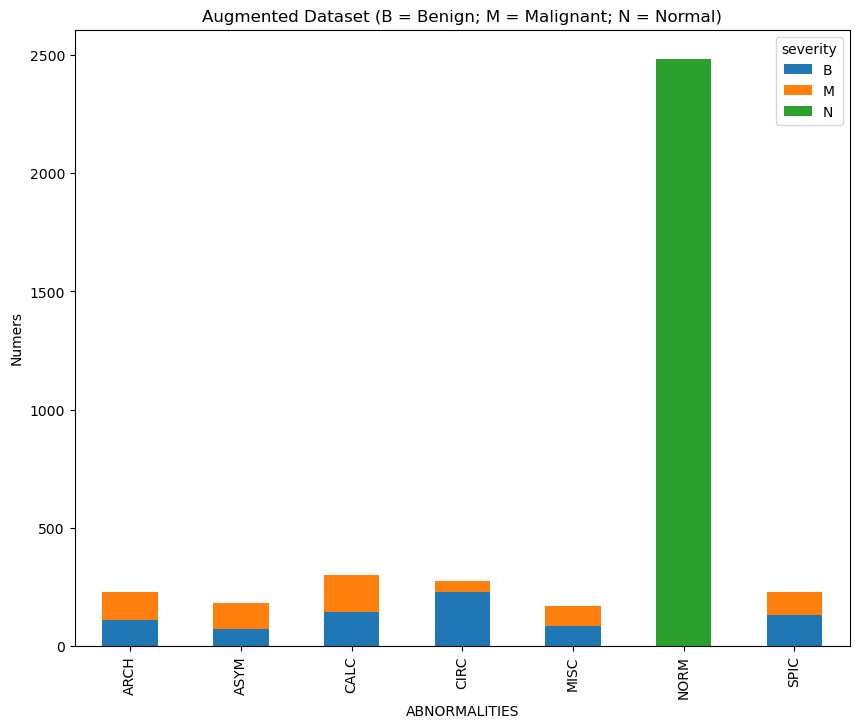

In [7]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES', 
                                                              ylabel='Numers',
                                                              title='Augmented Dataset (B = Benign; M = Malignant; N = Normal)');

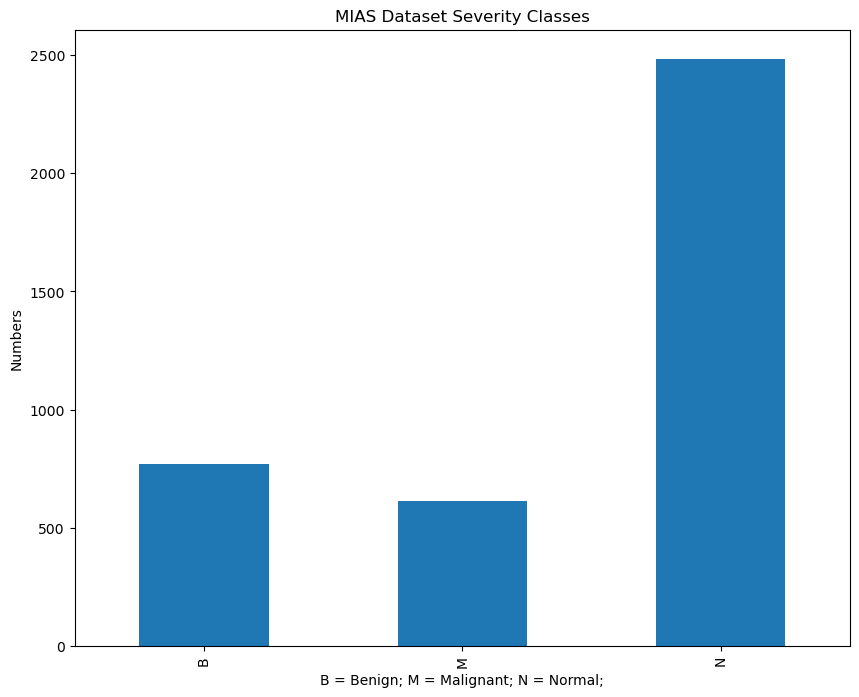

In [8]:
mias.groupby('severity').size().plot(kind='bar',stacked=True, 
                                                 figsize=(10, 8), 
                                                 xlabel='B = Benign; M = Malignant; N = Normal;', 
                                                 ylabel='Numbers',
                                                 title='MIAS Dataset Severity Classes');

## Dataframe ImageDataGen manipulation for Train, Val and Test set generation.

In [46]:
def dataset_gen(dataset):
    # def dataftrain(dataset):
    data_df = dataset
    # Split data into training, validation, and testing sets
    train_df, val_test_df = train_test_split(data_df, test_size=0.3, stratify=data_df['severity'])
    val_df, test_df = train_test_split(val_test_df, test_size=0.2, stratify=val_test_df['severity'])

   # Define data generators
    train_datagen = ImageDataGenerator(horizontal_flip=True,
                                      height_shift_range=.10, 
                                      width_shift_range=.10, 
                                      rotation_range=15,
                                      shear_range=10,
                                      rescale=1/255.)

    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)


#     train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

    # Define image size and batch size
    img_size = (48, 48)
    batch_size = 32
    color_mode = 'grayscale'
    class_mode = 'binary'
    
    # Training data generator
    train_data = train_datagen.flow_from_dataframe(
        train_df,
        x_col = 'subsample_path',
        y_col = 'severity',
        target_size = img_size,
        batch_size = batch_size,
        class_mode = class_mode,
        color_mode = color_mode,
        shuffle = True
    )

    # Validation data generator
    val_data = val_datagen.flow_from_dataframe(
        val_df,
        x_col = 'subsample_path',
        y_col = 'severity',
        target_size = img_size,
        batch_size = batch_size,
        class_mode = class_mode,
        color_mode = color_mode,
        shuffle  =False
    ) 

    # Testing data generator
    test_data = test_datagen.flow_from_dataframe(
        test_df,
        x_col = 'subsample_path',
        y_col = 'severity',
        target_size = img_size,
        batch_size = batch_size,
        class_mode = class_mode,
        color_mode = color_mode,
        shuffle = False
    )

    # Get the true class labels for the testing data
    test_labels = test_data.labels
    
    return train_data, val_data, test_data, test_labels

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### This trials will start using a basic CNN model, as the data at hand is little, makes sense to check how a small model approach performs over the samples at hand. 

## Training, Testing and Evaluation of methods for Calcifications

In [33]:
# # prepare dataset
# calc_balanced = balance_by_severity(mias, 'CALC')
# circ_balanced = balance_by_severity(mias, 'CIRC')
# spic_balanced = balance_by_severity(mias, 'SPIC')
# misc_balanced = balance_by_severity(mias, 'MISC')
# # create new dataframe for the masses only
# calc_mass_balanced = pd.concat([calc_balanced, circ_balanced, spic_balanced, misc_balanced])
# calc_mass_balanced

In [34]:
# circ_balanced = balance_by_severity(mias, 'CIRC')
# spic_balanced = balance_by_severity(mias, 'SPIC')
# misc_balanced = balance_by_severity(mias, 'MISC')
# asym_balanced = balance_by_severity(mias, 'ASYM')
# arch_balanced = balance_by_severity(mias, 'ARCH')
# unbalance_ab = pd.concat([circ_balanced, spic_balanced, misc_balanced, asym_balanced, arch_balanced])
# unbalance_ab

In [11]:
mias_calc = balance_by_severity(mias, 'CALC')
mias_calc

,ab_class,bg,severity,subsample_path,p_matrix
mdb212_0_rotated,CALC,G,B,../subsamples/mdb212_0_rotated.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
mdb212_0_mirr_lr,CALC,G,B,../subsamples/mdb212_0_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_0_mirr_tp,CALC,G,B,../subsamples/mdb212_0_mirr_tp.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
mdb212_90_rotated,CALC,G,B,../subsamples/mdb212_90_rotated.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_90_mirr_lr,CALC,G,B,../subsamples/mdb212_90_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
...,...,...,...,...,...
mdb209_270_mirr_lr,CALC,G,M,../subsamples/mdb209_270_mirr_lr.png,"[[206, 205, 205, 206, 206, 205, 203, 203, 203,..."
mdb233_90_mirr_tp,CALC,G,M,../subsamples/mdb233_90_mirr_tp.png,"[[77, 77, 77, 76, 76, 75, 75, 75, 74, 74, 74, ..."
mdb216_0_rotated,CALC,D,M,../subsamples/mdb216_0_rotated.png,"[[197, 197, 197, 196, 196, 196, 197, 198, 198,..."
mdb249_180_mirr_lr,CALC,D,M,../subsamples/mdb249_180_mirr_lr.png,"[[196, 196, 196, 195, 195, 194, 194, 194, 194,..."


In [37]:
calcifications_unbalanced = mias[mias.ab_class == 'CALC']
calcifications_unbalanced

,ab_class,bg,severity,subsample_path,p_matrix
mdb209_0_rotated,CALC,G,M,../subsamples/mdb209_0_rotated.png,"[[206, 206, 205, 204, 204, 203, 201, 200, 200,..."
mdb209_0_transposed,CALC,G,M,../subsamples/mdb209_0_transposed.png,"[[198, 200, 201, 202, 186, 186, 201, 202, 186,..."
mdb209_0_mirr_lr,CALC,G,M,../subsamples/mdb209_0_mirr_lr.png,"[[117, 117, 116, 115, 116, 116, 114, 116, 118,..."
mdb209_0_mirr_tp,CALC,G,M,../subsamples/mdb209_0_mirr_tp.png,"[[125, 126, 128, 132, 131, 131, 134, 132, 132,..."
mdb209_45_rotated,CALC,G,M,../subsamples/mdb209_45_rotated.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
mdb256_270_mirr_tp,CALC,F,M,../subsamples/mdb256_270_mirr_tp.png,"[[159, 159, 159, 159, 160, 160, 160, 160, 160,..."
mdb256_315_rotated,CALC,F,M,../subsamples/mdb256_315_rotated.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
mdb256_315_transposed,CALC,F,M,../subsamples/mdb256_315_transposed.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
mdb256_315_mirr_lr,CALC,F,M,../subsamples/mdb256_315_mirr_lr.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


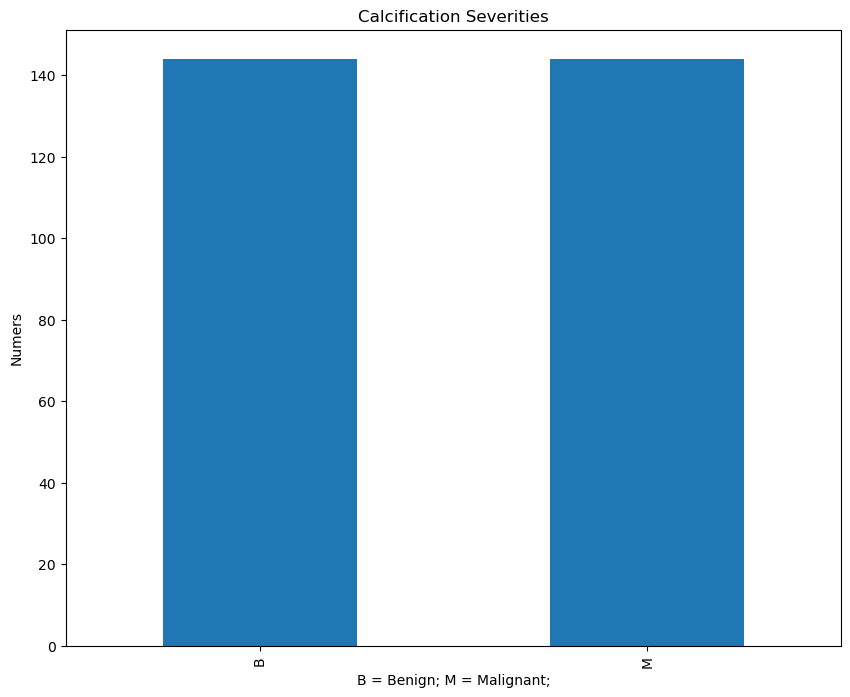

In [12]:
mias_calc.groupby('severity').size().plot(kind='bar',stacked=True, 
                                                 figsize=(10, 8), 
                                                 xlabel='B = Benign; M = Malignant;', 
                                                 ylabel='Numers',
                                                 title='Calcification Severities');

In [40]:
unbalance_ab.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES', 
                                                              ylabel='Numers',
                                                              title='Augmented Dataset (Severity: B = Benign; M = Malignant; N = Normal)');

NameError: name 'unbalance_ab' is not defined

In [ ]:
import cv2
import numpy as np

n = len(mias)
for i in range(7720, n):
    image = cv2.imread(mias.subsample_path[i])
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.show()
sample_img2 = cv2.imread(mias.subsample_path[3061])
color = cv2.cvtColor(sample_img2, cv2.COLOR_BGR2RGB)
plt.imshow(color)
# plt.title(mias.index[3062])
plt.show()

In [13]:
train_data, val_data, test_images, test_labels = dataset_gen(mias_calc)

Found 216 validated image filenames belonging to 2 classes.
Found 57 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 2 classes.


### Trial 0

### In this trial, the data samples used are derived from a combination of different data augmentation techniques. Althought, given the following result, the new data has proven too noisy, and not ideal for the model to learn the features from it. So the following 2 Trial show how even though chaning architectures and hyper parameters, this data is not ideal. Therefore, the Third Trial will use the original augmentation technique, which will include only 4 values or rotation and performing mirroring twice for every image, thus generating 12 images (including original) every original image.

In [14]:
model_c0 = Sequential()
model_c0.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_c0.add(MaxPool2D(pool_size=2, strides=2))
model_c0.add(Conv2D(64, kernel_size = (3, 3), activation='relu'))
model_c0.add(MaxPool2D(pool_size=2, strides=2))
model_c0.add(Flatten())
model_c0.add(Dense(16, activation = 'relu'))
model_c0.add(Dense(1, activation = 'sigmoid'))
model_c0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [48]:
# model_0 = Sequential()

# # first layer
# cnn_binary.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
# cnn_binary.add(MaxPool2D(pool_size=2, strides=2))
# cnn_binary.add(Conv2D(64, kernel_size = (3,3),activation='relu'))
# #                    kernel_regularizer='l1_l2')) # Lambda 0.01 by deault.
# cnn_binary.add(MaxPool2D(pool_size=2, strides=2))
# cnn_binary.add(Conv2D(128, kernel_size = (3,3),activation='relu'))
# #                    kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))
# cnn_binary.add(MaxPool2D(pool_size=2, strides=2))
# cnn_binary.add(Dropout(0.25))
# # flattening results
# cnn_binary.add(Flatten())
# cnn_binary.add(Dense(32, activation='relu', activity_regularizer = regularizers.l1(1e-3)))
# cnn_binary.add(Dropout(0.5))
# cnn_binary.add(Dense(16, activation='relu', activity_regularizer = regularizers.l1(1e-3)))
# cnn_binary.add(Dropout(0.25))
# cnn_binary.add(Dense(8, activation='relu', activity_regularizer = regularizers.l1(1e-3)))
# cnn_binary.add(Dropout(0.5))

# cnn_binary.add(Dense(1, activation='sigmoid')) # Binary Dense layer to produce final output
# cnn_binary.summary() # print summary

In [15]:
# set optmizer and learning rate
adam = Adam(0.0001)
model_c0.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

# Callback for checkpointing
model_check_point = ModelCheckpoint(filepath= 'best_model_c0[48x48].h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='auto', save_freq='epoch')
# Fit the samples
hist_c0 = model_c0.fit(train_data, validation_data=val_data, epochs=400,
                    callbacks=[early_stopping, model_check_point])

Epoch 1/400
7/7 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69007, saving model to best_model_0[48x48].h5
7/7 [==============================] - 2s 132ms/step - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6901 - val_accuracy: 0.5088
Epoch 2/400
7/7 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.69007 to 0.68918, saving model to best_model_0[48x48].h5
7/7 [==============================] - 1s 87ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.5088
Epoch 3/400
7/7 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5000
Epoch 3: val_loss improved from 0.68918 to 0.68872, saving model to best_model_0[48x48].h5
7/7 [==============================] - 1s 85ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6887 - val_accuracy: 0.5088
Epoch 4/400
7/7 [==============================] - ETA: 0s - loss: 

In [16]:
models.save_model(model_c0, 'model_c0[48x48].h5')

You had 0.19 val loss and acc of 0.9, Tune the dist. of dataset, hyperparameters and try again.

loss: 0.0786 - accuracy: 0.9688 - val_loss: 0.1278 - val_accuracy: 0.9667

In [17]:
# History of accuracy and loss
tra_loss_c0 = hist_c0.history['loss']
tra_acc_c0 = hist_c0.history['accuracy']
val_loss_c0 = hist_c0.history['val_loss']
val_acc_c0 = hist_c0.history['val_accuracy']

# Total number of epochs training
epochs_c0 = range(1, len(tra_acc_c0)+1)
end_epoch_c0 = len(tra_acc_c0)

# Epoch when reached the validation loss minimum
opt_epoch_c0 = val_loss_c0.index(min(val_loss_c0)) + 1

# Loss and accuracy on the validation set
end_val_loss_c0 = val_loss_c0[-1]
end_val_acc_c0 = val_acc_c0[-1]
opt_val_loss_c0 = val_loss_c0[opt_epoch_c0-1]
opt_val_acc_c0 = val_acc_c0[opt_epoch_c0-1]

# Loss and accuracy on the test set
opt_model_c0 = models.load_model('best_model_0[48x48].h5')
test_loss_c0, test_acc_c0 = model_c0.evaluate(test_images, verbose=False)
opt_test_loss_c0, opt_test_acc_c0 = opt_model_c0.evaluate(test_images, verbose=False)
opt_pred_c0 = opt_model_c0.predict(test_images)
pred_classes_c0 = np.rint(opt_pred_c0)

print("Model Calc 0\n")

print("Epoch [end]: %d" % end_epoch_c0)
print("Epoch [opt]: %d" % opt_epoch_c0)
print("Valid accuracy [end]: %.4f" % end_val_acc_c0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_c0)
print("Test accuracy [end]:  %.4f" % test_acc_c0)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_c0)
print("Valid loss [end]: %.4f" % end_val_loss_c0)
print("Valid loss [opt]: %.4f" % opt_val_loss_c0)
print("Test loss [end]:  %.4f" % test_loss_c0)
print("Test loss [opt]:  %.4f" % opt_test_loss_c0)

print(classification_report(test_labels, pred_classes_c0, digits=4))

1/1 [==============================] - 0s 153ms/step
Model Calc 0

Epoch [end]: 400
Epoch [opt]: 394
Valid accuracy [end]: 0.7018
Valid accuracy [opt]: 0.7368
Test accuracy [end]:  0.7333
Test accuracy [opt]:  0.8000
Valid loss [end]: 0.4413
Valid loss [opt]: 0.4399
Test loss [end]:  0.4944
Test loss [opt]:  0.4835
              precision    recall  f1-score   support

           0     0.8571    0.7500    0.8000         8
           1     0.7500    0.8571    0.8000         7

    accuracy                         0.8000        15
   macro avg     0.8036    0.8036    0.8000        15
weighted avg     0.8071    0.8000    0.8000        15



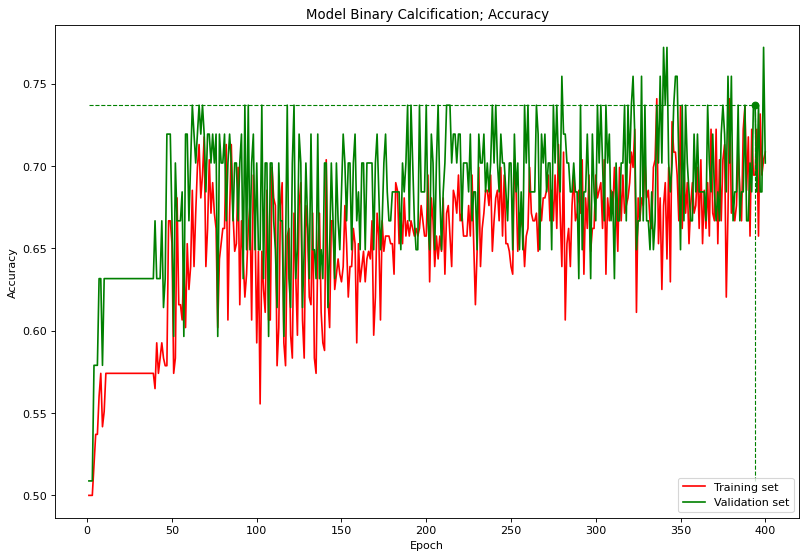

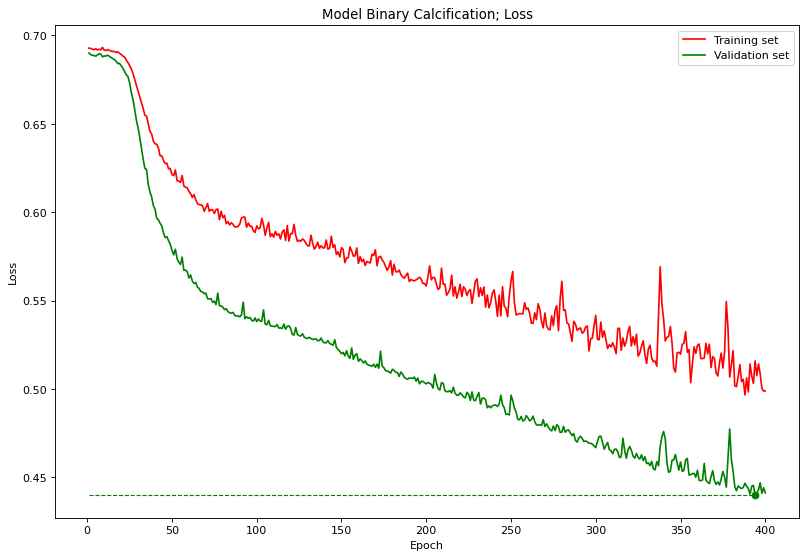

In [18]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_c0, tra_acc_c0, 'r', label='Training set')
plt.plot(epochs_c0, val_acc_c0, 'g', label='Validation set')
plt.plot(opt_epoch_c0, val_acc_c0[opt_epoch_c0-1], 'go')
plt.vlines(opt_epoch_c0, min(val_acc_c0), opt_val_acc_c0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_c0, 1, opt_epoch_c0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_c0, tra_loss_c0, 'r', label='Training set')
plt.plot(epochs_c0, val_loss_c0, 'g', label='Validation set')
plt.plot(opt_epoch_c0, val_loss_c0[opt_epoch_c0-1], 'go')
plt.vlines(opt_epoch_c0, min(val_loss_c0), opt_val_loss_c0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_c0, 1, opt_epoch_c0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# y_prob = all_mias.predict(test_data)

# # predictions labels; convert the output probabilities to class labels
# y_pred = np.argmax(y_prob, axis=1)

# # Calculate precision, recall, and F1-score
# precision = precision_score(test_labels, y_pred, average='weighted')
# recall = recall_score(test_labels, y_pred, average='weighted')
# f1 = f1_score(test_labels, y_pred, average='weighted')

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")

In [ ]:
# val_pred = np.argmax(opt_model.predict(test_data), axis=-1)
# # pred_1_classes = opt_model_1.predict(test_images)
# confusion_mtx = confusion_matrix(test_labels, val_pred) 
# plot_confusion_matrix(confusion_mtx, classes=range(2), title='Confusion matrix')
# # plot_confusion_matrix.savefig('ConfusionMatrix.png')

## Trail 1

### Based on the previous model and training results, the hyper parameters need to be adjusted, particularly steps per epochs, and batch size to escape the local minima at early stage. The model didn't perfom great either, some more complexity will be added. This class is clearly not so diverse in terms of features, therefore the fitting requires more attention, for the model to not get stuck into redundant calculations. Batch size is changed to 16, from the function.

In [27]:
model_c1 = Sequential()
model_c1.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_c1.add(MaxPool2D(pool_size=2, strides=2))
model_c1.add(Conv2D(68, kernel_size = (3, 3),activation='relu'))
model_c1.add(MaxPool2D(pool_size=2, strides=2))
model_c1.add(Conv2D(128, kernel_size = (3, 3),activation='relu'))
model_c1.add(MaxPool2D(pool_size=2, strides=2))
model_c1.add(Flatten())
model_c1.add(Dense(32, activation = 'relu'))
model_c1.add(Dropout(0.25))
model_c1.add(Dense(1, activation = 'sigmoid'))
model_c1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 68)        19652     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 10, 68)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         78464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 128)       

In [28]:
# set optmizer and learning rate
# adam = tf.keras.optimizers.RMSprop(0.001)
adam = Adam(0.0001)
model_c1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

# Callback for checkpointing
model_check_point = ModelCheckpoint(filepath= 'best_model_c1[48x48].h5', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='auto', save_freq='epoch')
# Fit the samples
hist_c1 = model_c1.fit(train_data, validation_data=val_data, epochs=400, 
#                     steps_per_epoch=len(train_data),
#                     validation_steps=len(val_data),
                    callbacks=[early_stopping, model_check_point])

Epoch 1/400
7/7 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.4491
Epoch 1: val_loss improved from inf to 0.69035, saving model to best_model_c1[48x48].h5
7/7 [==============================] - 2s 158ms/step - loss: 0.7079 - accuracy: 0.4491 - val_loss: 0.6904 - val_accuracy: 0.6140
Epoch 2/400
7/7 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5185
Epoch 2: val_loss improved from 0.69035 to 0.68838, saving model to best_model_c1[48x48].h5
7/7 [==============================] - 1s 106ms/step - loss: 0.6926 - accuracy: 0.5185 - val_loss: 0.6884 - val_accuracy: 0.6316
Epoch 3/400
7/7 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5741
Epoch 3: val_loss improved from 0.68838 to 0.68392, saving model to best_model_c1[48x48].h5
7/7 [==============================] - 1s 98ms/step - loss: 0.6927 - accuracy: 0.5741 - val_loss: 0.6839 - val_accuracy: 0.6316
Epoch 4/400
6/7 [========================>.....] - ETA: 0s - lo

In [21]:
models.save_model(model_c1, 'model_c1[48x48].h5')

In [23]:
# History of accuracy and loss
tra_loss_c1 = hist_c1.history['loss']
tra_acc_c1 = hist_c1.history['accuracy']
val_loss_c1 = hist_c1.history['val_loss']
val_acc_c1 = hist_c1.history['val_accuracy']

# Total number of epochs training
epochs_c1 = range(1, len(tra_acc_c1)+1)
end_epoch_c1 = len(tra_acc_c1)

# Epoch when reached the validation loss minimum
opt_epoch_c1 = val_loss_c1.index(min(val_loss_c1)) + 1

# Loss and accuracy on the validation set
end_val_loss_c1 = val_loss_c1[-1]
end_val_acc_c1 = val_acc_c1[-1]
opt_val_loss_c1 = val_loss_c1[opt_epoch_c1-1]
opt_val_acc_c1 = val_acc_c1[opt_epoch_c1-1]

# Loss and accuracy on the test set
opt_model_c1 = models.load_model('model_c1[48x48].h5')
test_loss_c1, test_acc_c1 = model_c1.evaluate(test_images, verbose=False)
opt_test_loss_c1, opt_test_acc_c1 = opt_model_c1.evaluate(test_images, verbose=False)
opt_pred_c1 = opt_model_c1.predict(test_images)
pred_classes_c1 = np.rint(opt_pred_c1)

print("Model Calc 0\n")

print("Epoch [end]: %d" % end_epoch_c1)
print("Epoch [opt]: %d" % opt_epoch_c1)
print("Valid accuracy [end]: %.4f" % end_val_acc_c1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_c1)
print("Test accuracy [end]:  %.4f" % test_acc_c1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_c1)
print("Valid loss [end]: %.4f" % end_val_loss_c1)
print("Valid loss [opt]: %.4f" % opt_val_loss_c1)
print("Test loss [end]:  %.4f" % test_loss_c1)
print("Test loss [opt]:  %.4f" % opt_test_loss_c1)

print(classification_report(test_labels, pred_classes_c1, digits=4))

1/1 [==============================] - 0s 136ms/step
Model Calc 0

Epoch [end]: 200
Epoch [opt]: 196
Valid accuracy [end]: 0.7544
Valid accuracy [opt]: 0.7719
Test accuracy [end]:  0.7333
Test accuracy [opt]:  0.7333
Valid loss [end]: 0.4561
Valid loss [opt]: 0.3991
Test loss [end]:  0.5067
Test loss [opt]:  0.5067
              precision    recall  f1-score   support

           0     0.7000    0.8750    0.7778         8
           1     0.8000    0.5714    0.6667         7

    accuracy                         0.7333        15
   macro avg     0.7500    0.7232    0.7222        15
weighted avg     0.7467    0.7333    0.7259        15



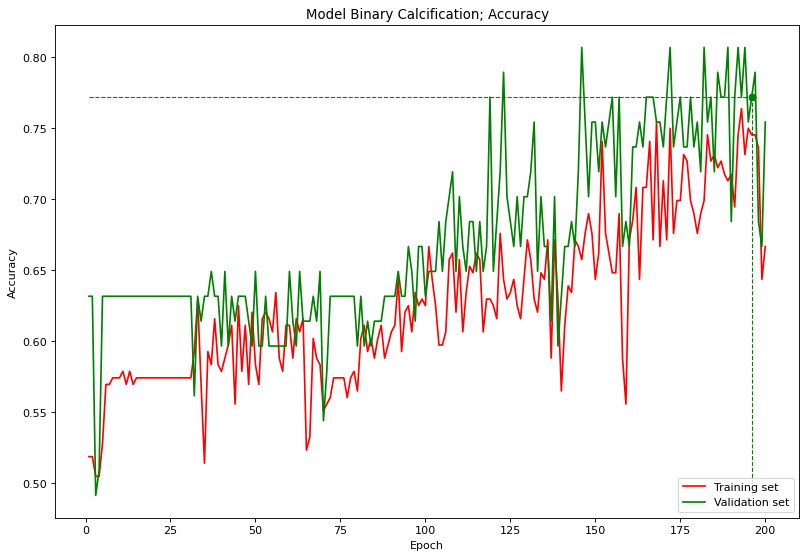

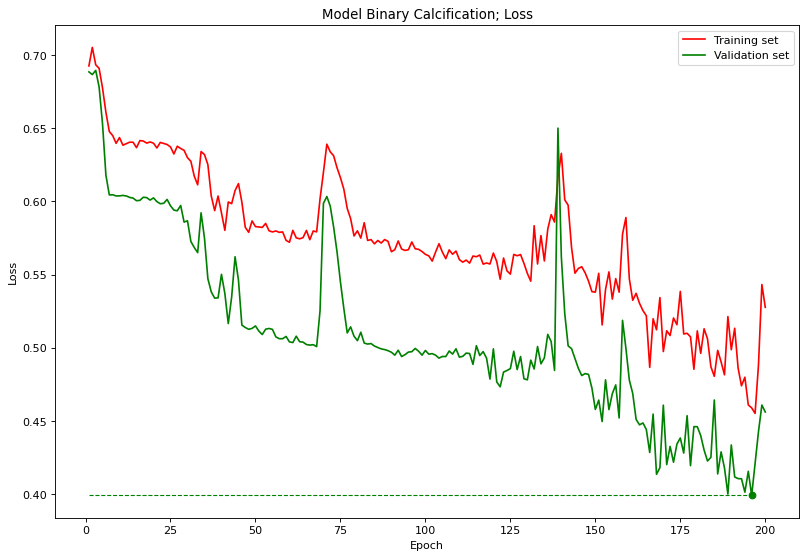

In [24]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_c1, tra_acc_c1, 'r', label='Training set')
plt.plot(epochs_c1, val_acc_c1, 'g', label='Validation set')
plt.plot(opt_epoch_c1, val_acc_c1[opt_epoch_c1-1], 'go')
plt.vlines(opt_epoch_c1, min(val_acc_c1), opt_val_acc_c1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_c1, 1, opt_epoch_c1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_c1, tra_loss_c1, 'r', label='Training set')
plt.plot(epochs_c1, val_loss_c1, 'g', label='Validation set')
plt.plot(opt_epoch_c1, val_loss_c1[opt_epoch_c1-1], 'go')
plt.vlines(opt_epoch_c1, min(val_loss_c1), opt_val_loss_c1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_c1, 1, opt_epoch_c1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Trial 2

### The previous two trials demonstrate the use of an unfeasible data, generated via too many data augmentation techniques. Therefore, the original data augmentation method is implemented, using the previously added new techniques only on the ImageDataGenerator, perfomring data aug on the fly, diversifying the data, without creating too much noise.

In [114]:
mias_calc = balance_by_severity(mias, 'CALC')
mias_calc

,ab_class,bg,severity,subsample_path,p_matrix
mdb212_0_rotated,CALC,G,B,../subsamples/mdb212_0_rotated.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
mdb212_0_mirr_lr,CALC,G,B,../subsamples/mdb212_0_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_0_mirr_tp,CALC,G,B,../subsamples/mdb212_0_mirr_tp.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,..."
mdb212_90_rotated,CALC,G,B,../subsamples/mdb212_90_rotated.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_90_mirr_lr,CALC,G,B,../subsamples/mdb212_90_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
...,...,...,...,...,...
mdb256_270_mirr_lr,CALC,F,M,../subsamples/mdb256_270_mirr_lr.png,"[[173, 173, 173, 174, 174, 174, 173, 171, 170,..."
mdb253_0_rotated,CALC,D,M,../subsamples/mdb253_0_rotated.png,"[[196, 196, 196, 196, 196, 197, 197, 197, 197,..."
mdb209_0_rotated,CALC,G,M,../subsamples/mdb209_0_rotated.png,"[[206, 206, 205, 204, 204, 203, 201, 200, 200,..."
mdb256_0_mirr_lr,CALC,F,M,../subsamples/mdb256_0_mirr_lr.png,"[[162, 162, 162, 161, 160, 159, 158, 158, 158,..."


In [115]:
train_data, val_data, test_images, test_labels = dataset_gen(mias_calc)

Found 201 validated image filenames belonging to 2 classes.
Found 69 validated image filenames belonging to 2 classes.
Found 18 validated image filenames belonging to 2 classes.


In [39]:
model_c2 = Sequential()
model_c2.add(Conv2D(16, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_c2.add(MaxPool2D(pool_size=2, strides=2))
model_c2.add(Conv2D(32, kernel_size = (3, 3),activation='relu'))
model_c2.add(MaxPool2D(pool_size=2, strides=2))
model_c2.add(Conv2D(64, kernel_size = (3, 3),activation='relu'))
model_c2.add(MaxPool2D(pool_size=2, strides=2))
# model_c2.add(Dropout(0.25))
model_c2.add(Flatten())
model_c2.add(Dense(16, activation = 'relu', activity_regularizer = regularizers.l2(1e-5)))
# model_c2.add(Dropout(0.5))
model_c2.add(Dense(1, activation = 'sigmoid'))
model_c2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 23, 23, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 4, 4, 64)        

In [40]:
# set optmizer and learning rate
adam = Adam(0.0001)
model_c2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

# Callback for checkpointing
model_check_point = ModelCheckpoint(filepath= './CNN/Calc', monitor='val_loss', verbose=1, 
                                    save_best_only=True, save_weights_only=False, 
                                    mode='auto', save_freq='epoch')
# Fit the samples
hist_c2 = model_c2.fit(train_data, validation_data=val_data, epochs=400,
#                        batch_size = 512,
#                        steps_per_epoch=(len(train_data) // batch_size),
#                     steps_per_epoch=len(train_data),
#                     validation_steps=len(val_data),
                    callbacks=[early_stopping, model_check_point])

Epoch 1/300
6/7 [========================>.....] - ETA: 0s - loss: 0.6967 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69608, saving model to ./CNN/Calc
7/7 [==============================] - 3s 351ms/step - loss: 0.6964 - accuracy: 0.5000 - val_loss: 0.6961 - val_accuracy: 0.4912
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.69608 to 0.69372, saving model to ./CNN/Calc
7/7 [==============================] - 2s 292ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.4912
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5231
Epoch 3: val_loss improved from 0.69372 to 0.69218, saving model to ./CNN/Calc
7/7 [==============================] - 2s 299ms/step - loss: 0.6934 - accuracy: 0.5231 - val_loss: 0.6922 - val_accuracy: 0.5965
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5556
Epoch 4:

In [41]:
models.save_model(model_c2, './CNN/Calc/model_2[48x48].h5')

In [42]:
# History of accuracy and loss
tra_loss_c2 = hist_c2.history['loss']
tra_acc_c2 = hist_c2.history['accuracy']
val_loss_c2 = hist_c2.history['val_loss']
val_acc_c2 = hist_c2.history['val_accuracy']

# Total number of epochs training
epochs_c2 = range(1, len(tra_acc_c2)+1)
end_epoch_c2 = len(tra_acc_c2)

# Epoch when reached the validation loss minimum
opt_epoch_c2 = val_loss_c2.index(min(val_loss_c2)) + 1

# Loss and accuracy on the validation set
end_val_loss_c2 = val_loss_c2[-1]
end_val_acc_c2 = val_acc_c2[-1]
opt_val_loss_c2 = val_loss_c2[opt_epoch_c2-1]
opt_val_acc_c2 = val_acc_c2[opt_epoch_c2-1]

# Loss and accuracy on the test set
opt_model_c2 = models.load_model('./CNN/Calc/model_2[48x48].h5')
test_loss_c2, test_acc_c2 = model_c2.evaluate(test_images, verbose=False)
opt_test_loss_c2, opt_test_acc_c2 = opt_model_c2.evaluate(test_images, verbose=False)
opt_pred_c2 = opt_model_c2.predict(test_images)
pred_classes_c2 = np.rint(opt_pred_c2)

print("Model Calc 2\n")

print("Epoch [end]: %d" % end_epoch_c2)
print("Epoch [opt]: %d" % opt_epoch_c2)
print("Valid accuracy [end]: %.4f" % end_val_acc_c2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_c2)
print("Test accuracy [end]:  %.4f" % test_acc_c2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_c2)
print("Valid loss [end]: %.4f" % end_val_loss_c2)
print("Valid loss [opt]: %.4f" % opt_val_loss_c2)
print("Test loss [end]:  %.4f" % test_loss_c2)
print("Test loss [opt]:  %.4f" % opt_test_loss_c2)

print(classification_report(test_labels, pred_classes_c2, digits=4))

1/1 [==============================] - 0s 135ms/step
Model Calc 2

Epoch [end]: 300
Epoch [opt]: 298
Valid accuracy [end]: 0.6842
Valid accuracy [opt]: 0.7018
Test accuracy [end]:  0.8000
Test accuracy [opt]:  0.8000
Valid loss [end]: 0.5115
Valid loss [opt]: 0.5099
Test loss [end]:  0.5359
Test loss [opt]:  0.5359
              precision    recall  f1-score   support

           0     0.7273    1.0000    0.8421         8
           1     1.0000    0.5714    0.7273         7

    accuracy                         0.8000        15
   macro avg     0.8636    0.7857    0.7847        15
weighted avg     0.8545    0.8000    0.7885        15



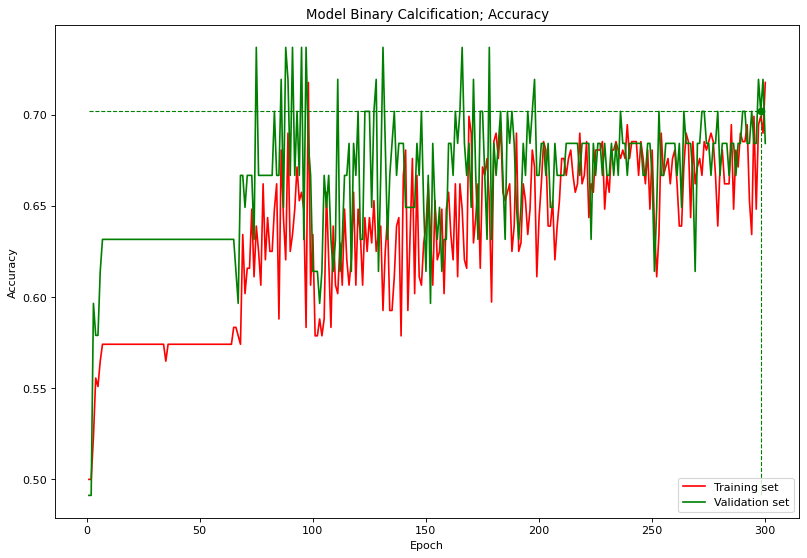

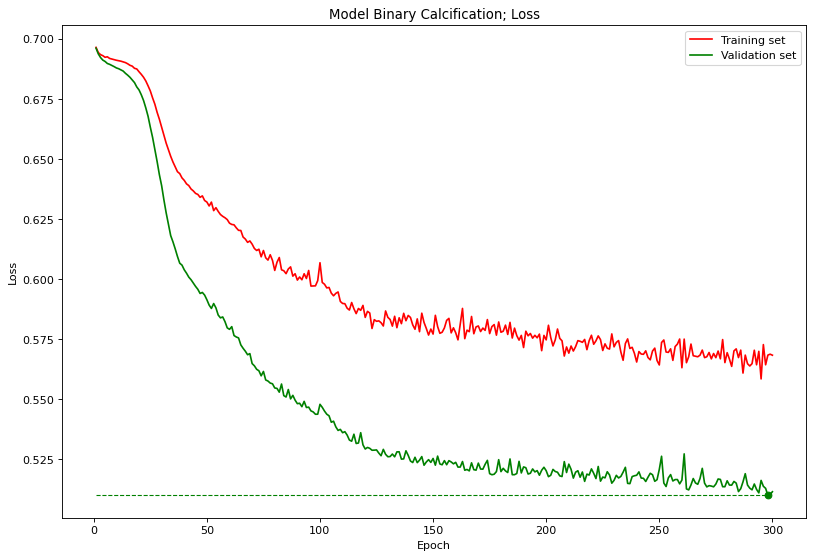

In [43]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_c2, tra_acc_c2, 'r', label='Training set')
plt.plot(epochs_c2, val_acc_c2, 'g', label='Validation set')
plt.plot(opt_epoch_c2, val_acc_c2[opt_epoch_c2-1], 'go')
plt.vlines(opt_epoch_c2, min(val_acc_c2), opt_val_acc_c2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_c2, 1, opt_epoch_c2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_c2, tra_loss_c2, 'r', label='Training set')
plt.plot(epochs_c2, val_loss_c2, 'g', label='Validation set')
plt.plot(opt_epoch_c2, val_loss_c2[opt_epoch_c2-1], 'go')
plt.vlines(opt_epoch_c2, min(val_loss_c2), opt_val_loss_c2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_c2, 1, opt_epoch_c2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### The problem with this abnormality class (CALC), is that the data is too little in volume and number of features as the model can not diversify over the data, and gets stuck in the local minima multiple times. Efford have been made to cure this problem via data augmentation, to generate more samples to help the model diversifying, but without success as the data was too noisy, and the model couldn't distinguish it as it should have. This type of classification will be abandonded, as it proved that CALC data is too fragile and incomplete for such goal.

## Training, Testing and Evaluation of model for Masses

### The data agumentation techniques were kept and tried over the Mass classification task too, althought it was at this point that such combination of techniques all together proved to create noisy data, even for a more complete set of data class Mass composed of three ab classes (CIRC, SPIC and MISC). The model had the same symptoms of getting stuck in local minima, without learning well. So a retieve of steps approach was taken, to get back when Mass was yielding a decent result, and improve that.

In [47]:
# prepare dataset
circ_balanced = balance_by_severity(mias, 'CIRC')
spic_balanced = balance_by_severity(mias, 'SPIC')
misc_balanced = balance_by_severity(mias, 'MISC')
# create new dataframe for the masses only
masses_balanced = pd.concat([circ_balanced, spic_balanced, misc_balanced])
masses_balanced

,ab_class,bg,severity,subsample_path,p_matrix
mdb005_180_rotated,CIRC,F,B,../subsamples/mdb005_180_rotated.png,"[[84, 84, 84, 84, 84, 84, 84, 85, 86, 87, 87, ..."
mdb091_0_mirr_lr,CIRC,F,B,../subsamples/mdb091_0_mirr_lr.png,"[[178, 178, 178, 178, 178, 177, 177, 177, 176,..."
mdb315_90_mirr_lr,CIRC,D,B,../subsamples/mdb315_90_mirr_lr.png,"[[151, 150, 150, 149, 143, 140, 139, 143, 144,..."
mdb142_0_mirr_tp,CIRC,F,B,../subsamples/mdb142_0_mirr_tp.png,"[[152, 152, 152, 152, 153, 153, 154, 154, 154,..."
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png,"[[125, 128, 113, 102, 98, 94, 91, 94, 97, 99, ..."
...,...,...,...,...,...
mdb267_180_mirr_tp,MISC,F,M,../subsamples/mdb267_180_mirr_tp.png,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
mdb267_90_mirr_tp,MISC,F,M,../subsamples/mdb267_90_mirr_tp.png,"[[163, 163, 164, 165, 164, 163, 163, 163, 163,..."
mdb264_180_rotated,MISC,G,M,../subsamples/mdb264_180_rotated.png,"[[84, 84, 84, 84, 84, 84, 86, 88, 89, 91, 92, ..."
mdb058_0_mirr_tp,MISC,D,M,../subsamples/mdb058_0_mirr_tp.png,"[[161, 161, 161, 161, 160, 160, 159, 159, 157,..."


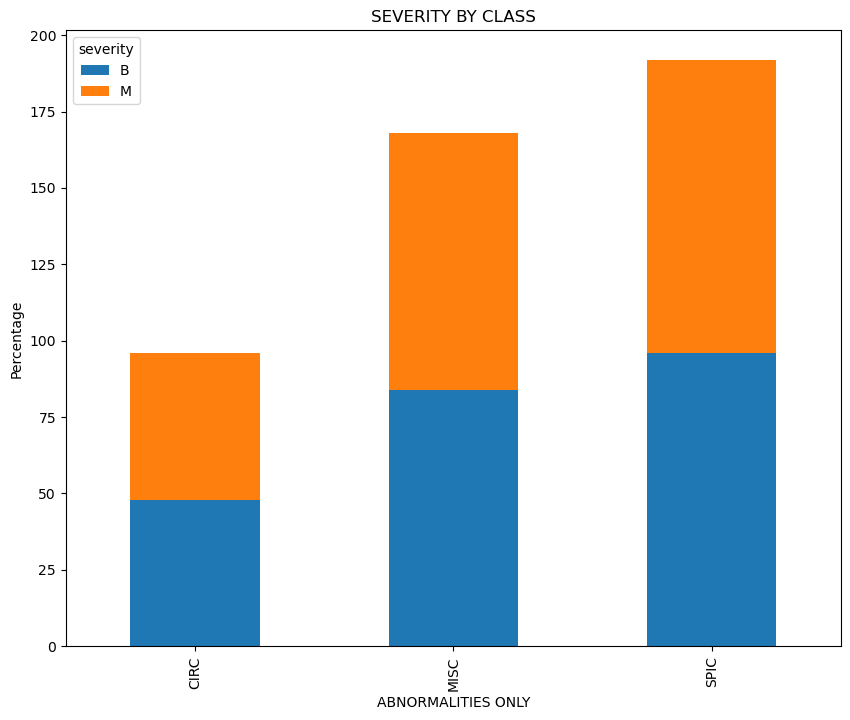

In [142]:
masses_balanced.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', stacked=True, 
                                                                                    figsize=(10, 8), 
                                                                                    xlabel='ABNORMALITIES ONLY', 
                                                                                    ylabel='Percentage',
                                                                                    title='SEVERITY BY CLASS');

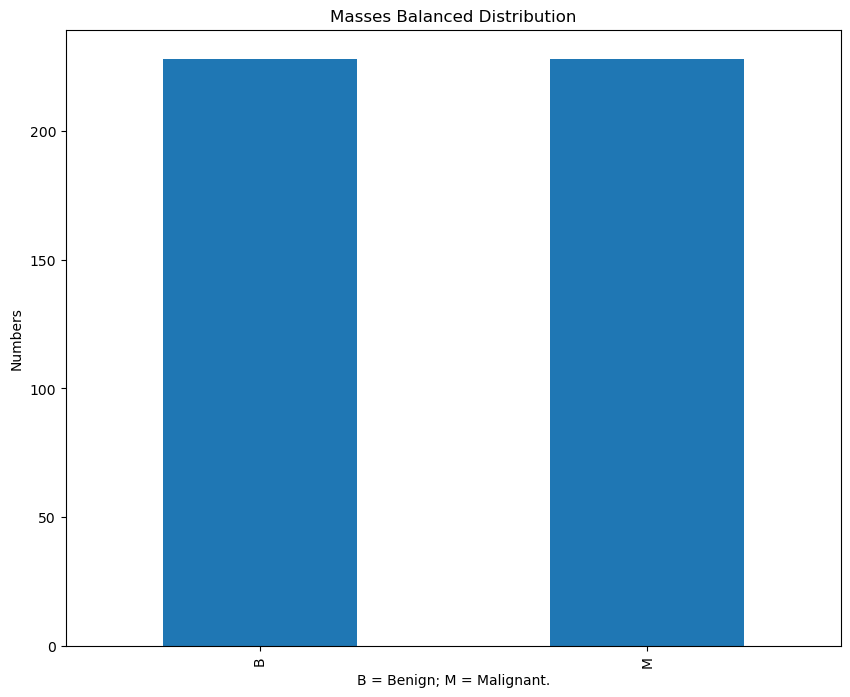

In [143]:
masses_balanced.groupby('severity').size().plot(kind='bar',stacked=True, 
                                                 figsize=(10, 8), 
                                                 xlabel='B = Benign; M = Malignant.',
                                                 ylabel='Numbers',
                                                 title='Masses Balanced Distribution');

In [48]:
train_data, val_data, test_data, test_labels = dataset_gen(masses_balanced)

Found 319 validated image filenames belonging to 2 classes.
Found 109 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.


## Trial 0

In [57]:
model_m0 = Sequential()
model_m0.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_m0.add(MaxPool2D(pool_size=2, strides=2))
model_m0.add(Conv2D(64, kernel_size = (3, 3),activation='relu'))
model_m0.add(MaxPool2D(pool_size=2, strides=2))
model_m0.add(Flatten())
model_m0.add(Dense(16, activation='relu'))
# model_m0.add(Dropout(0.25))
model_m0.add(Dense(1, activation='sigmoid'))
model_m0.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 6400)              0         
                                                                 
 dense_20 (Dense)            (None, 16)              

In [58]:
# set optmizer and learning rate
adam = Adam(0.001)
model_m0.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= 'model_m0[48x48].h5', monitor='val_loss',
                                    verbose=1, save_best_only=True, save_weights_only=False, 
                                    mode='min', save_freq='epoch')
# Train the model
hist_m0 = model_m0.fit(train_data, validation_data=val_data, epochs=400,
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/400
10/10 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.5235
Epoch 1: val_loss improved from inf to 0.69290, saving model to model_m0[48x48].h5
10/10 [==============================] - 2s 113ms/step - loss: 0.7019 - accuracy: 0.5235 - val_loss: 0.6929 - val_accuracy: 0.4954
Epoch 2/400
10/10 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5016
Epoch 2: val_loss improved from 0.69290 to 0.69286, saving model to model_m0[48x48].h5
10/10 [==============================] - 1s 93ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6929 - val_accuracy: 0.5596
Epoch 3/400
10/10 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.4796
Epoch 3: val_loss improved from 0.69286 to 0.69251, saving model to model_m0[48x48].h5
10/10 [==============================] - 1s 93ms/step - loss: 0.6957 - accuracy: 0.4796 - val_loss: 0.6925 - val_accuracy: 0.4954
Epoch 4/400
10/10 [==============================] - ETA: 0s - loss

In [59]:
models.save_model(model_m0, 'model_m0[48x48].h5')

In [60]:
# History of accuracy and loss
tra_loss_m0 = hist_m0.history['loss']
tra_acc_m0 = hist_m0.history['accuracy']
val_loss_m0 = hist_m0.history['val_loss']
val_acc_m0 = hist_m0.history['val_accuracy']

# Total number of epochs training
epochs_m0 = range(1, len(tra_acc_m0)+1)
end_epoch_m0 = len(tra_acc_m0)

# Epoch when reached the validation loss minimum
opt_epoch_m0 = val_loss_m0.index(min(val_loss_m0)) + 1

# Loss and accuracy on the validation set
end_val_loss_m0 = val_loss_m0[-1]
end_val_acc_m0 = val_acc_m0[-1]
opt_val_loss_m0 = val_loss_m0[opt_epoch_m0-1]
opt_val_acc_m0 = val_acc_m0[opt_epoch_m0-1]

# Loss and accuracy on the test set
opt_model_m0 = models.load_model('model_m0[48x48].h5')
test_loss_m0, test_acc_m0 = model_m0.evaluate(test_data, verbose=False)
opt_test_loss_m0, opt_test_acc_m0 = opt_model_m0.evaluate(test_data, verbose=False)
opt_pred_m0 = opt_model_m0.predict(test_data)
pred_classes_m0 = np.rint(opt_pred_m0)

print("Model Mass 0\n")

print("Epoch [end]: %d" % end_epoch_m0)
print("Epoch [opt]: %d" % opt_epoch_m0)
print("Valid accuracy [end]: %.4f" % end_val_acc_m0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_m0)
print("Test accuracy [end]:  %.4f" % test_acc_m0)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_m0)
print("Valid loss [end]: %.4f" % end_val_loss_m0)
print("Valid loss [opt]: %.4f" % opt_val_loss_m0)
print("Test loss [end]:  %.4f" % test_loss_m0)
print("Test loss [opt]:  %.4f" % opt_test_loss_m0)

print(classification_report(test_labels, pred_classes_m0, digits=4))

1/1 [==============================] - 0s 132ms/step
Model Mass 0

Epoch [end]: 400
Epoch [opt]: 377
Valid accuracy [end]: 0.8440
Valid accuracy [opt]: 0.8899
Test accuracy [end]:  0.8571
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.3908
Valid loss [opt]: 0.3339
Test loss [end]:  0.3708
Test loss [opt]:  0.3708
              precision    recall  f1-score   support

           0     0.8571    0.8571    0.8571        14
           1     0.8571    0.8571    0.8571        14

    accuracy                         0.8571        28
   macro avg     0.8571    0.8571    0.8571        28
weighted avg     0.8571    0.8571    0.8571        28



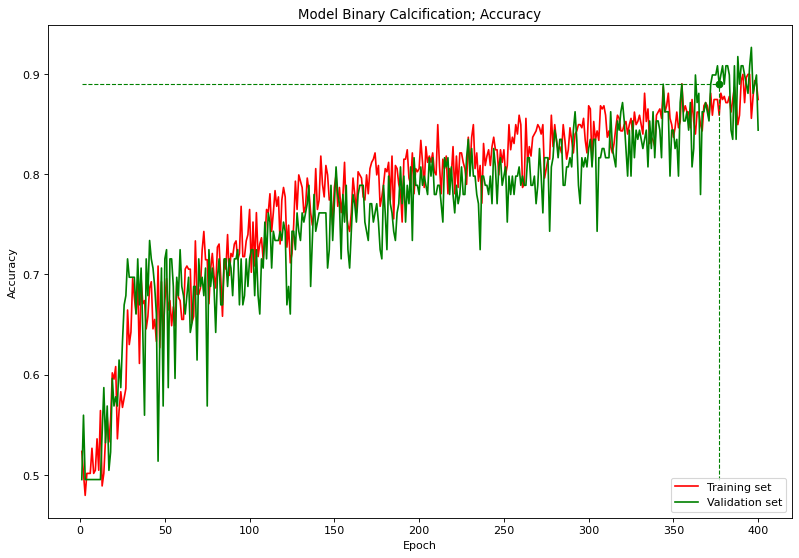

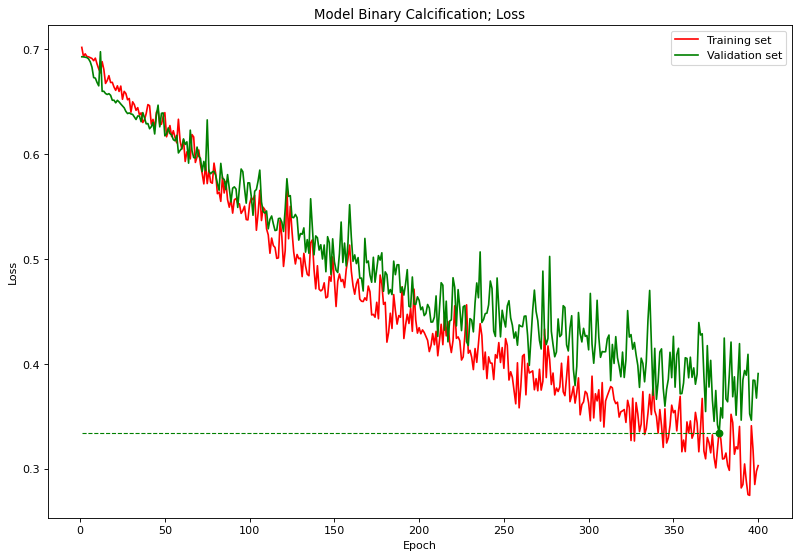

In [61]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_m0, tra_acc_m0, 'r', label='Training set')
plt.plot(epochs_m0, val_acc_m0, 'g', label='Validation set')
plt.plot(opt_epoch_m0, val_acc_m0[opt_epoch_m0-1], 'go')
plt.vlines(opt_epoch_m0, min(val_acc_m0), opt_val_acc_m0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_m0, 1, opt_epoch_m0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_m0, tra_loss_m0, 'r', label='Training set')
plt.plot(epochs_m0, val_loss_m0, 'g', label='Validation set')
plt.plot(opt_epoch_m0, val_loss_m0[opt_epoch_m0-1], 'go')
plt.vlines(opt_epoch_m0, min(val_loss_m0), opt_val_loss_m0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_m0, 1, opt_epoch_m0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Trial 1

In [64]:
model_m1 = Sequential()
model_m1.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_m1.add(MaxPool2D(pool_size=2, strides=2))
model_m1.add(Conv2D(64, kernel_size = (3,3),activation='relu'))
model_m1.add(MaxPool2D(pool_size=2, strides=2))
model_m1.add(Conv2D(128, kernel_size = (3,3),activation='relu'))
model_m1.add(MaxPool2D(pool_size=2, strides=2))
model_m1.add(Flatten())
model_m1.add(Dense(32, activation='relu'))
# model_m1.add(Dropout(0.25))
model_m1.add(Dense(1, activation='sigmoid'))
model_m1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 4, 4, 128)      

In [65]:
# set optmizer and learning rate
adam = Adam(0.001)
model_m1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= 'model_m1[48x48].h5', monitor='val_loss',
                                    verbose=1, save_best_only=True, save_weights_only=False, 
                                    mode='min', save_freq='epoch')
# Train the model
hist_m1 = model_m1.fit(train_data, validation_data=val_data, epochs=400,
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/400
10/10 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.4984
Epoch 1: val_loss improved from inf to 0.69304, saving model to model_m1[48x48].h5
10/10 [==============================] - 2s 127ms/step - loss: 0.6948 - accuracy: 0.4984 - val_loss: 0.6930 - val_accuracy: 0.4954
Epoch 2/400
10/10 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5016
Epoch 2: val_loss did not improve from 0.69304
10/10 [==============================] - 1s 95ms/step - loss: 0.6934 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.4954
Epoch 3/400
10/10 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5110
Epoch 3: val_loss improved from 0.69304 to 0.69300, saving model to model_m1[48x48].h5
10/10 [==============================] - 1s 100ms/step - loss: 0.6932 - accuracy: 0.5110 - val_loss: 0.6930 - val_accuracy: 0.4954
Epoch 4/400
10/10 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4828
Epoch 4: va

In [66]:
models.save_model(model_m1, 'model_m1[48x48].h5')

In [67]:
# History of accuracy and loss
tra_loss_m1 = hist_m1.history['loss']
tra_acc_m1 = hist_m1.history['accuracy']
val_loss_m1 = hist_m1.history['val_loss']
val_acc_m1 = hist_m1.history['val_accuracy']

# Total number of epochs training
epochs_m1 = range(1, len(tra_acc_m1)+1)
end_epoch_m1 = len(tra_acc_m1)

# Epoch when reached the validation loss minimum
opt_epoch_m1 = val_loss_m1.index(min(val_loss_m1)) + 1

# Loss and accuracy on the validation set
end_val_loss_m1 = val_loss_m1[-1]
end_val_acc_m1 = val_acc_m1[-1]
opt_val_loss_m1 = val_loss_m1[opt_epoch_m1-1]
opt_val_acc_m1 = val_acc_m1[opt_epoch_m1-1]

# Loss and accuracy on the test set
opt_model_m1 = models.load_model('model_m1[48x48].h5')
test_loss_m1, test_acc_m1 = model_m1.evaluate(test_data, verbose=False)
opt_test_loss_m1, opt_test_acc_m1 = opt_model_m1.evaluate(test_data, verbose=False)
opt_pred_m1 = opt_model_m1.predict(test_data)
pred_classes_m1 = np.rint(opt_pred_m1)

print("Model Mass 1\n")

print("Epoch [end]: %d" % end_epoch_m1)
print("Epoch [opt]: %d" % opt_epoch_m1)
print("Valid accuracy [end]: %.4f" % end_val_acc_m1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_m1)
print("Test accuracy [end]:  %.4f" % test_acc_m1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_m1)
print("Valid loss [end]: %.4f" % end_val_loss_m1)
print("Valid loss [opt]: %.4f" % opt_val_loss_m1)
print("Test loss [end]:  %.4f" % test_loss_m1)
print("Test loss [opt]:  %.4f" % opt_test_loss_m1)

print(classification_report(test_labels, pred_classes_m1, digits=2))

1/1 [==============================] - 0s 152ms/step
Model Mass 1

Epoch [end]: 362
Epoch [opt]: 312
Valid accuracy [end]: 0.8073
Valid accuracy [opt]: 0.9266
Test accuracy [end]:  0.8571
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.5728
Valid loss [opt]: 0.2500
Test loss [end]:  0.3183
Test loss [opt]:  0.3183
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.86      0.86      0.86        14

    accuracy                           0.86        28
   macro avg       0.86      0.86      0.86        28
weighted avg       0.86      0.86      0.86        28



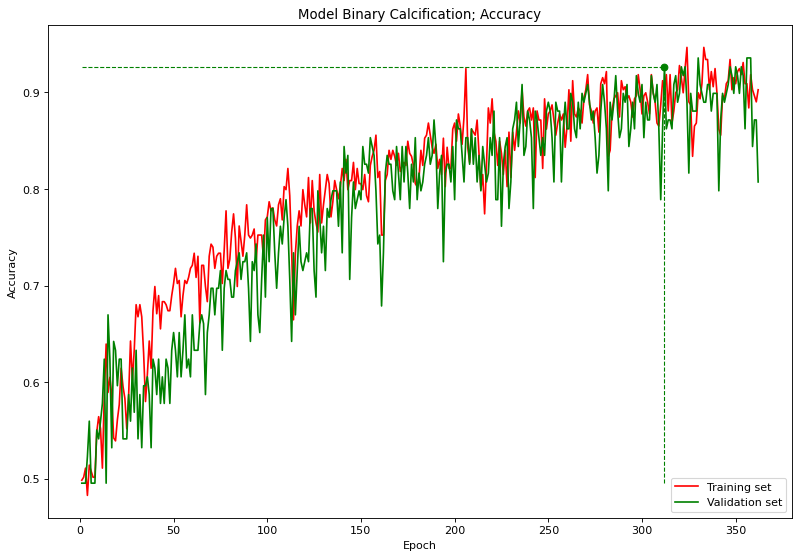

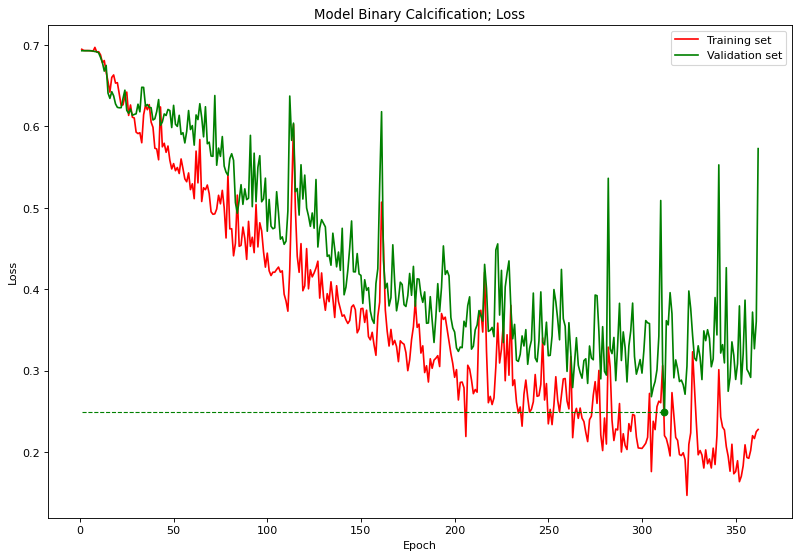

In [68]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_m1, tra_acc_m1, 'r', label='Training set')
plt.plot(epochs_m1, val_acc_m1, 'g', label='Validation set')
plt.plot(opt_epoch_m1, val_acc_m1[opt_epoch_m1-1], 'go')
plt.vlines(opt_epoch_m1, min(val_acc_m1), opt_val_acc_m1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_m1, 1, opt_epoch_m1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_m1, tra_loss_m1, 'r', label='Training set')
plt.plot(epochs_m1, val_loss_m1, 'g', label='Validation set')
plt.plot(opt_epoch_m1, val_loss_m1[opt_epoch_m1-1], 'go')
plt.vlines(opt_epoch_m1, min(val_loss_m1), opt_val_loss_m1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_m1, 1, opt_epoch_m1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### This time the model has perfomed better, increasing the perfomance by learning the data better thanks to a more nodes and an extra Conv layer. Although, the complexity has also generated extra features and more oscillation during learning. This will be fixed with regularization techniques.

## Trial 2

### L2 will be applied to the FC32, Dropout added before Flatten. The value of L2 will be a "delicate" 0.0001, and dropout 0.25. This will to gently regulazing the learning variation, without interfeering too much. This should allow for a steadier rithm, so 50 extra epochs are added.

In [86]:
model_m2 = Sequential()
model_m2.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(48, 48, 1)))
model_m2.add(MaxPool2D(pool_size=2, strides=2))
model_m2.add(Conv2D(64, kernel_size = (3,3),activation='relu'))
model_m2.add(MaxPool2D(pool_size=2, strides=2))
model_m2.add(Conv2D(128, kernel_size = (3,3),activation='relu'))
model_m2.add(MaxPool2D(pool_size=2, strides=2))
# model_m2.add(Conv2D(256, kernel_size = (3,3),activation='relu'))
# model_m2.add(MaxPool2D(pool_size=2, strides=2))
# model_m2.add(Dropout(0.25))
model_m2.add(Flatten())
model_m2.add(Dense(32, activation='relu', activity_regularizer = regularizers.l2(1e-3)))
model_m2.add(Dropout(0.25))
model_m2.add(Dense(1, activation='sigmoid'))
model_m2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 4, 4, 128)      

In [87]:
# set optmizer and learning rate
adam = Adam(0.001)
model_m2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= 'best_model_m2[48x48].h5', monitor='val_loss',
                                    verbose=1, save_best_only=True, save_weights_only=False, 
                                    mode='min', save_freq='epoch')
# Train the model
hist_m2 = model_m2.fit(train_data, validation_data=val_data, epochs=400,
#                     steps_per_epoch=len(train_data),
#                     validation_steps=len(val_data),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/400
10/10 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.4859
Epoch 1: val_loss improved from inf to 0.69290, saving model to model_m2[48x48].h5
10/10 [==============================] - 2s 133ms/step - loss: 0.6948 - accuracy: 0.4859 - val_loss: 0.6929 - val_accuracy: 0.4954
Epoch 2/400
10/10 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5110
Epoch 2: val_loss improved from 0.69290 to 0.69254, saving model to model_m2[48x48].h5
10/10 [==============================] - 1s 103ms/step - loss: 0.6942 - accuracy: 0.5110 - val_loss: 0.6925 - val_accuracy: 0.4954
Epoch 3/400
10/10 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4859
Epoch 3: val_loss improved from 0.69254 to 0.69201, saving model to model_m2[48x48].h5
10/10 [==============================] - 1s 105ms/step - loss: 0.6937 - accuracy: 0.4859 - val_loss: 0.6920 - val_accuracy: 0.4954
Epoch 4/400
10/10 [==============================] - ETA: 0s - lo

In [88]:
models.save_model(model_m2, 'model_m2[48x48].h5')

In [89]:
# History of accuracy and loss
tra_loss_m2 = hist_m2.history['loss']
tra_acc_m2 = hist_m2.history['accuracy']
val_loss_m2 = hist_m2.history['val_loss']
val_acc_m2 = hist_m2.history['val_accuracy']

# Total number of epochs training
epochs_m2 = range(1, len(tra_acc_m2)+1)
end_epoch_m2 = len(tra_acc_m2)

# Epoch when reached the validation loss minimum
opt_epoch_m2 = val_loss_m2.index(min(val_loss_m2)) + 1

# Loss and accuracy on the validation set
end_val_loss_m2 = val_loss_m2[-1]
end_val_acc_m2 = val_acc_m2[-1]
opt_val_loss_m2 = val_loss_m2[opt_epoch_m2-1]
opt_val_acc_m2 = val_acc_m2[opt_epoch_m2-1]

# Loss and accuracy on the test set
opt_model_m2 = models.load_model('model_m2[48x48].h5')
test_loss_m2, test_acc_m2 = model_m2.evaluate(test_data, verbose=False)
opt_test_loss_m2, opt_test_acc_m2 = opt_model_m2.evaluate(test_data, verbose=False)
opt_pred_m2 = opt_model_m2.predict(test_data)
pred_classes_m2 = np.rint(opt_pred_m2)

print("Model Mass 2\n")

print("Epoch [end]: %d" % end_epoch_m2)
print("Epoch [opt]: %d" % opt_epoch_m2)
print("Valid accuracy [end]: %.4f" % end_val_acc_m2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_m2)
print("Test accuracy [end]:  %.4f" % test_acc_m2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_m2)
print("Valid loss [end]: %.4f" % end_val_loss_m2)
print("Valid loss [opt]: %.4f" % opt_val_loss_m2)
print("Test loss [end]:  %.4f" % test_loss_m2)
print("Test loss [opt]:  %.4f" % opt_test_loss_m2)

print(classification_report(test_labels, pred_classes_m2, digits=4))

1/1 [==============================] - 0s 161ms/step
Model Mass 2

Epoch [end]: 399
Epoch [opt]: 349
Valid accuracy [end]: 0.8532
Valid accuracy [opt]: 0.8899
Test accuracy [end]:  0.8571
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.3052
Valid loss [opt]: 0.2999
Test loss [end]:  0.2996
Test loss [opt]:  0.2996
              precision    recall  f1-score   support

           0     0.8571    0.8571    0.8571        14
           1     0.8571    0.8571    0.8571        14

    accuracy                         0.8571        28
   macro avg     0.8571    0.8571    0.8571        28
weighted avg     0.8571    0.8571    0.8571        28



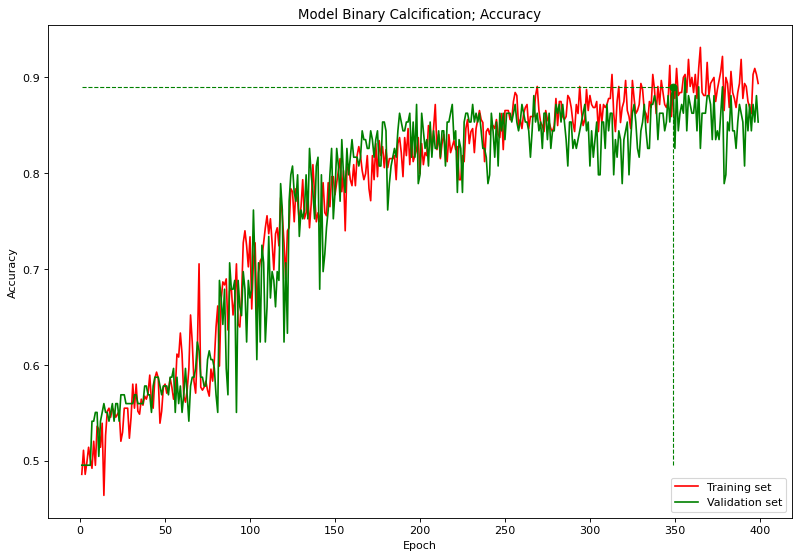

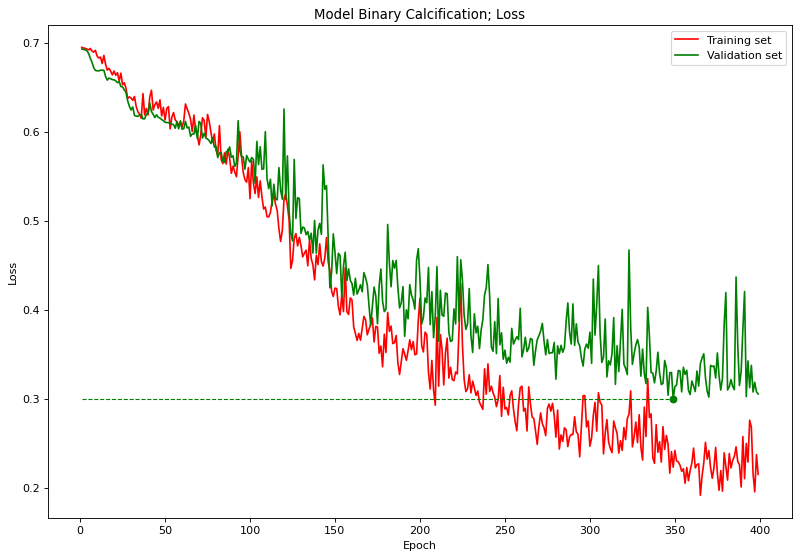

In [90]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_m2, tra_acc_m2, 'r', label='Training set')
plt.plot(epochs_m2, val_acc_m2, 'g', label='Validation set')
plt.plot(opt_epoch_m2, val_acc_m2[opt_epoch_m2-1], 'go')
plt.vlines(opt_epoch_m2, min(val_acc_m2), opt_val_acc_m2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_m2, 1, opt_epoch_m2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_m2, tra_loss_m2, 'r', label='Training set')
plt.plot(epochs_m2, val_loss_m2, 'g', label='Validation set')
plt.plot(opt_epoch_m2, val_loss_m2[opt_epoch_m2-1], 'go')
plt.vlines(opt_epoch_m2, min(val_loss_m2), opt_val_loss_m2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_m2, 1, opt_epoch_m2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## This result is reassuring the fact that, the model can't be too complex, and too many parameters may critically unbalance the learning phase, an extra Trial will be performed, to see if the learning variance can be adjusted and controlled, so to extend training epochs, to reach a better performance.

## Trial 3

### Increasing size of first Conv's kernel, and reducing last Conv's kernel size.

In [81]:
model_m3 = Sequential()
model_m3.add(Conv2D(32, kernel_size = (5, 5), activation='relu', input_shape=(48, 48, 1)))
model_m3.add(MaxPool2D(pool_size=2, strides=2))
model_m3.add(Conv2D(64, kernel_size = (3, 3),activation='relu'))
model_m3.add(MaxPool2D(pool_size=2, strides=2))
model_m3.add(Conv2D(128, kernel_size = (2, 2),activation='relu'))
model_m3.add(MaxPool2D(pool_size=2, strides=2))
model_m3.add(Dropout(0.25))
# model_m3.add(Conv2D(256, kernel_size = (3, 3),activation='relu'))
# model_m3.add(MaxPool2D(pool_size=2, strides=2))
# model_m3.add(Dropout(0.25))
model_m3.add(Flatten())
model_m3.add(Dense(32, activation='relu', activity_regularizer = regularizers.l2(1e-3)))
model_m3.add(Dropout(0.25))
# model_m3.add(Dense(16, activation='relu', activity_regularizer = regularizers.l2(1e-4)))
# model_m3.add(Dropout(0.25))
model_m3.add(Dense(1, activation='sigmoid'))
model_m3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 44, 44, 32)        832       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 9, 9, 128)         32896     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 4, 4, 128)      

In [82]:
# set optmizer and learning rate
adam = Adam(0.001)
model_m3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'min', verbose = 1)

model_checkpoint = ModelCheckpoint(filepath= 'model_m3[48x48].h5', monitor='val_loss',
                                    verbose=1, save_best_only=True, save_weights_only=False, 
                                    mode='min', save_freq='epoch')
# Train the model
hist_m3 = model_m3.fit(train_data, validation_data=val_data, epochs=400,
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle = True, verbose = 1, initial_epoch=0)

Epoch 1/400
10/10 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.4357
Epoch 1: val_loss improved from inf to 0.69290, saving model to model_m3[48x48].h5
10/10 [==============================] - 2s 131ms/step - loss: 0.6980 - accuracy: 0.4357 - val_loss: 0.6929 - val_accuracy: 0.4954
Epoch 2/400
10/10 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4765
Epoch 2: val_loss did not improve from 0.69290
10/10 [==============================] - 1s 116ms/step - loss: 0.6942 - accuracy: 0.4765 - val_loss: 0.6930 - val_accuracy: 0.4954
Epoch 3/400
10/10 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5235
Epoch 3: val_loss did not improve from 0.69290
10/10 [==============================] - 1s 101ms/step - loss: 0.6933 - accuracy: 0.5235 - val_loss: 0.6930 - val_accuracy: 0.4954
Epoch 4/400
10/10 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5016
Epoch 4: val_loss improved from 0.69290 to 0.69288

In [83]:
models.save_model(model_m3, 'model_m3[48x48].h5')

In [84]:
# History of accuracy and loss
tra_loss_m3 = hist_m3.history['loss']
tra_acc_m3 = hist_m3.history['accuracy']
val_loss_m3 = hist_m3.history['val_loss']
val_acc_m3 = hist_m3.history['val_accuracy']

# Total number of epochs training
epochs_m3 = range(1, len(tra_acc_m3)+1)
end_epoch_m3 = len(tra_acc_m3)

# Epoch when reached the validation loss minimum
opt_epoch_m3 = val_loss_m3.index(min(val_loss_m3)) + 1

# Loss and accuracy on the validation set
end_val_loss_m3 = val_loss_m3[-1]
end_val_acc_m3 = val_acc_m3[-1]
opt_val_loss_m3 = val_loss_m3[opt_epoch_m3-1]
opt_val_acc_m3 = val_acc_m3[opt_epoch_m3-1]

# Loss and accuracy on the test set
opt_model_m3 = models.load_model('model_m3[48x48].h5')
test_loss_m3, test_acc_m3 = model_m3.evaluate(test_data, verbose=False)
opt_test_loss_m3, opt_test_acc_m3 = opt_model_m3.evaluate(test_data, verbose=False)
opt_pred_m3 = opt_model_m3.predict(test_data)
pred_classes_m3 = np.rint(opt_pred_m3)

print("Model Mass 2\n")

print("Epoch [end]: %d" % end_epoch_m3)
print("Epoch [opt]: %d" % opt_epoch_m3)
print("Valid accuracy [end]: %.4f" % end_val_acc_m3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_m3)
print("Test accuracy [end]:  %.4f" % test_acc_m3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_m3)
print("Valid loss [end]: %.4f" % end_val_loss_m3)
print("Valid loss [opt]: %.4f" % opt_val_loss_m3)
print("Test loss [end]:  %.4f" % test_loss_m3)
print("Test loss [opt]:  %.4f" % opt_test_loss_m3)

print(classification_report(test_labels, pred_classes_m3, digits=4))

1/1 [==============================] - 0s 165ms/step
Model Mass 2

Epoch [end]: 400
Epoch [opt]: 394
Valid accuracy [end]: 0.7890
Valid accuracy [opt]: 0.8440
Test accuracy [end]:  0.9286
Test accuracy [opt]:  0.9286
Valid loss [end]: 0.4537
Valid loss [opt]: 0.4092
Test loss [end]:  0.3211
Test loss [opt]:  0.3211
              precision    recall  f1-score   support

           0     0.9286    0.9286    0.9286        14
           1     0.9286    0.9286    0.9286        14

    accuracy                         0.9286        28
   macro avg     0.9286    0.9286    0.9286        28
weighted avg     0.9286    0.9286    0.9286        28



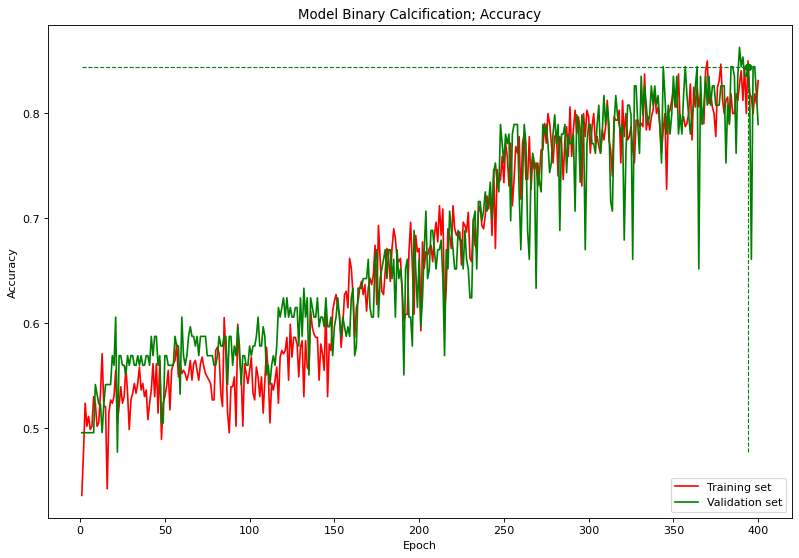

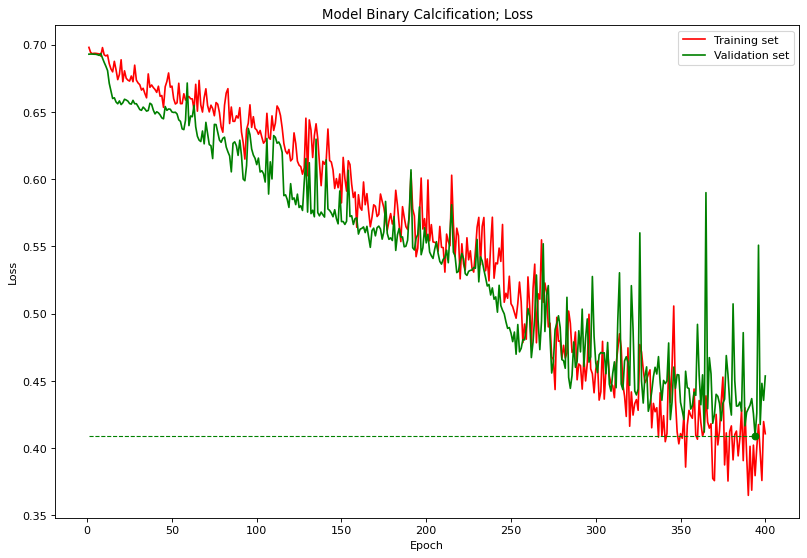

In [85]:
# Model accuracy
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_m3, tra_acc_m3, 'r', label='Training set')
plt.plot(epochs_m3, val_acc_m3, 'g', label='Validation set')
plt.plot(opt_epoch_m3, val_acc_m3[opt_epoch_m3-1], 'go')
plt.vlines(opt_epoch_m3, min(val_acc_m3), opt_val_acc_m3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_m3, 1, opt_epoch_m3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model Binary Calcification; Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_m3, tra_loss_m3, 'r', label='Training set')
plt.plot(epochs_m3, val_loss_m3, 'g', label='Validation set')
plt.plot(opt_epoch_m3, val_loss_m3[opt_epoch_m3-1], 'go')
plt.vlines(opt_epoch_m3, min(val_loss_m3), opt_val_loss_m3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_m3, 1, opt_epoch_m3, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Visualize Results

In [ ]:
# # predictions
# predictions = cnn_binary.predict(test_data)
# predicted = [np.argmax(w) for w in predictions]
# expected = test_data.labels

# # Evaluation Results
# loss_value, accuracy = cnn_binary.evaluate(train_data)
# print(f'Test loss_value: {loss_value}')
# print(f'Test accuracy: {accuracy}')

In [ ]:
# y_prob = all_mias.predict(test_data)

# # predictions labels; convert the output probabilities to class labels
# y_pred = np.argmax(y_prob, axis=1)

# # Calculate precision, recall, and F1-score
# precision = precision_score(test_labels, y_pred, average='weighted')
# recall = recall_score(test_labels, y_pred, average='weighted')
# f1 = f1_score(test_labels, y_pred, average='weighted')

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-score: {f1:.4f}")

In [ ]:
val_pred = np.argmax(opt_model.predict(test_data), axis=-1)
pred_1_classes = opt_model_1.predict(test_data)
confusion_mtx = confusion_matrix(test_labels, val_pred) 
plot_confusion_matrix(confusion_mtx, classes=range(2), title='Confusion matrix')
# plot_confusion_matrix.savefig('ConfusionMatrix.png')

## Compare results via Precision, Recall, F-1 Score and ROC curve.

In [91]:
def get_errors(pred):
    errors = []
    mispred = []
    hard_mispred = []

    for l,p,img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))
        if err > 0.8:
            hard_mispred.append((l,p,img))

    return errors, mispred, hard_mispred


def show_error_stats(errors, mispred, hard_mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))
    print("Hard mispred: %d" % len(hard_mispred))

    sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in hard_mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        plt.axis('off')


opt_model_m0 = models.load_model('model_m0[48x48].h5')
opt_model_m1 = models.load_model('model_m1[48x48].h5')
opt_model_m2 = models.load_model('model_m2[48x48].h5')
opt_model_m3 = models.load_model('model_m3[48x48].h5')

pred_m0 = opt_model_m0.predict(test_data)
pred_m1 = opt_model_m1.predict(test_data)
pred_m2 = opt_model_m0.predict(test_data)
pred_m3 = opt_model_m3.predict(test_data)

errors_m0, mispred_m0, hard_mispred_m0 = get_errors(pred_m0)
errors_m1, mispred_m1, hard_mispred_m1 = get_errors(pred_m1)
errors_m2, mispred_m2, hard_mispred_m2 = get_errors(pred_m2)

1/1 [==============================] - 0s 166ms/step


Number of test images: 28
Mispredictions: 4
Hard mispred: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



TypeError: tuple indices must be integers or slices, not tuple

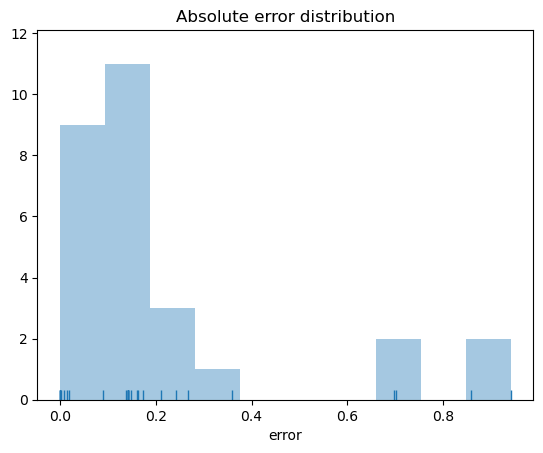

<Figure size 640x480 with 0 Axes>

In [92]:
show_error_stats(errors_m0, mispred_m0, hard_mispred_m0)

Number of test images: 28
Mispredictions: 4
Hard mispred: 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



TypeError: tuple indices must be integers or slices, not tuple

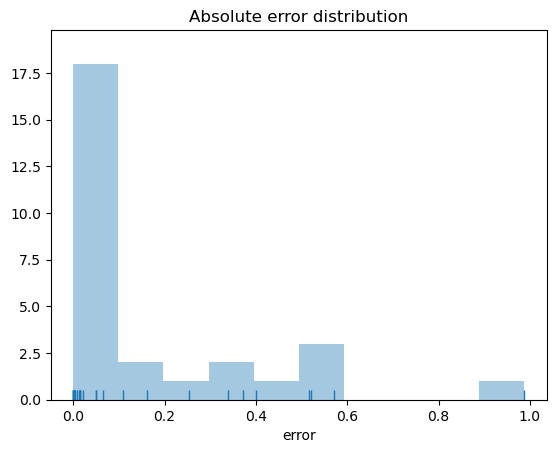

<Figure size 640x480 with 0 Axes>

In [93]:
show_error_stats(errors_m1, mispred_m1, hard_mispred_m1)

Number of test images: 28
Mispredictions: 4
Hard mispred: 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



TypeError: tuple indices must be integers or slices, not tuple

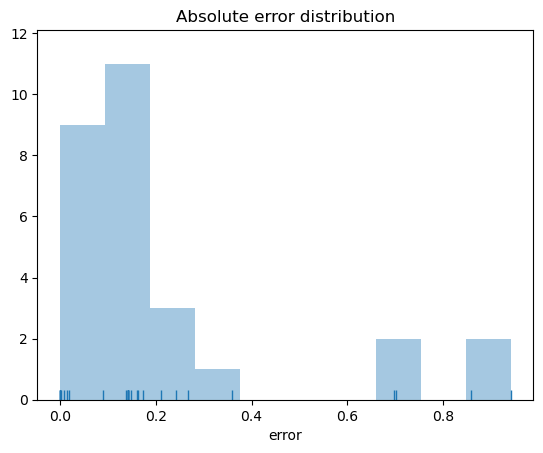

<Figure size 640x480 with 0 Axes>

In [94]:
show_error_stats(errors_m2, mispred_m2, hard_mispred_m2)

In [95]:
correct_m0 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_m0), test_labels)])
correct_m1 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_m1), test_labels)])
correct_m2 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_m2), test_labels)])

wrong_m0 = np.logical_not(correct_m0)
wrong_m1 = np.logical_not(correct_m1)
wrong_m2 = np.logical_not(correct_m2)

hard_wrong_m0 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_m0), test_labels)])
hard_wrong_m1 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_m1), test_labels)])
hard_wrong_m2 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_m2), test_labels)])

differ_m0_m1 = np.logical_xor(correct_m0, correct_m1)
differ_m0_m2 = np.logical_xor(correct_m0, correct_m2)
differ_m1_m2 = np.logical_xor(correct_m1, correct_m2)

wrong_all = np.logical_and(wrong_m0, wrong_m1, wrong_m2)
hard_wrong_all = np.logical_and(hard_wrong_m0, hard_wrong_m1, hard_wrong_m2)

In [96]:
print("0 and 1 differ for %d samples" % np.sum(differ_m0_m1))
print("0 and 2 differ for %d samples" % np.sum(differ_m0_m2))
print("1 and 2 differ for %d samples" % np.sum(differ_m1_m2))

print("%d samples were misclassified by all three" % np.sum(wrong_all))
print("%d samples were hard misclassified by all three" % np.sum(hard_wrong_all))

0 and 1 differ for 2 samples
0 and 2 differ for 0 samples
1 and 2 differ for 2 samples
3 samples were misclassified by all three
1 samples were hard misclassified by all three


In [97]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1/1 [==============================] - 0s 89ms/step


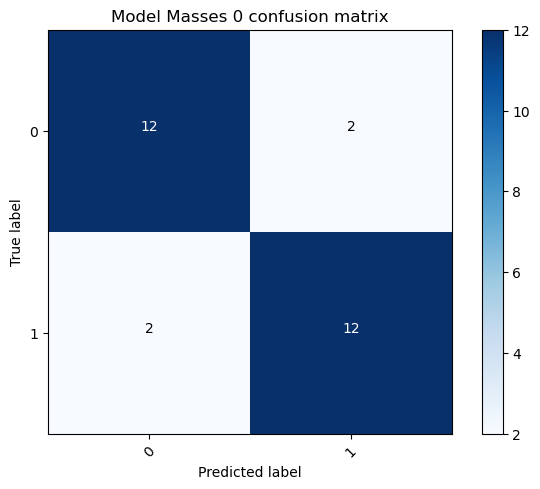

In [98]:
pred_m0_classes = np.rint(opt_model_m0.predict(test_data))
confusion_mtx = confusion_matrix(test_labels, pred_m0_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model Masses 0 confusion matrix')
plt.savefig('ConfusionMatrix_Modelm0.png')

1/1 [==============================] - 0s 93ms/step


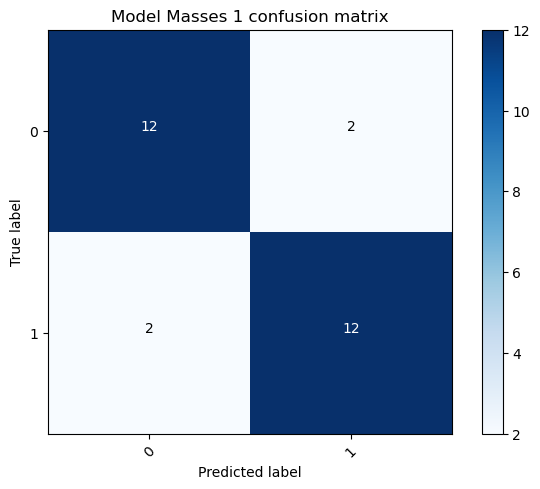

In [99]:
pred_m1_classes = np.rint(opt_model_m1.predict(test_data))
confusion_mtx = confusion_matrix(test_labels, pred_m1_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model Masses 1 confusion matrix')
plt.savefig('ConfusionMatrix_Modelm1.png')

1/1 [==============================] - 0s 99ms/step


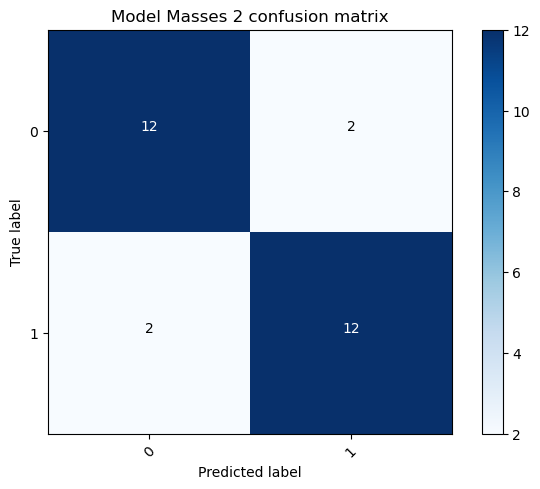

In [104]:
pred_m2_classes = np.rint(opt_model_m2.predict(test_data))
confusion_mtx = confusion_matrix(test_labels, pred_m2_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model Masses 2 confusion matrix')
plt.savefig('ConfusionMatrix_Modelm2.png')

1/1 [==============================] - 0s 87ms/step


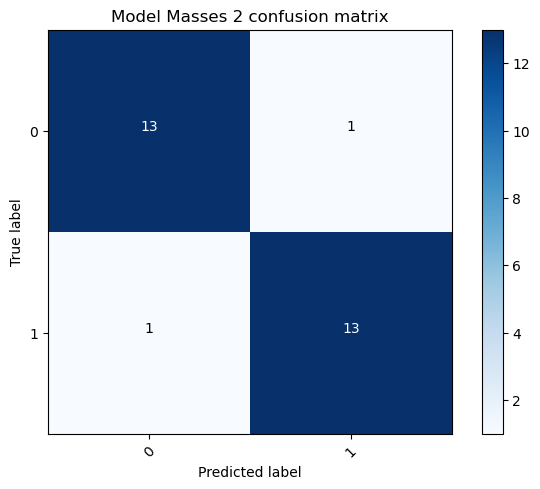

In [105]:
pred_m3_classes = np.rint(opt_model_m3.predict(test_data))
confusion_mtx = confusion_matrix(test_labels, pred_m3_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model Masses 2 confusion matrix')
plt.savefig('ConfusionMatrix_Modelm3.png')

In [101]:
def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

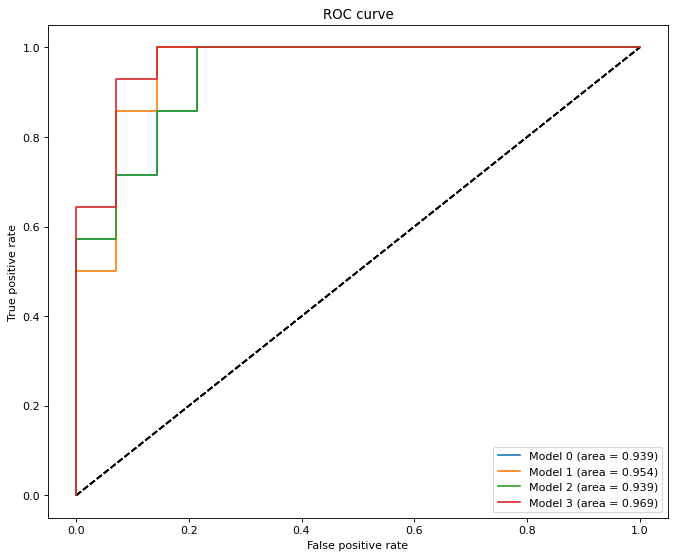

In [102]:
plot_roc([pred_m0, pred_m1, pred_m2, pred_m3], names=['Model 0', 'Model 1', 'Model 2', 'Model 3'])